In [1]:
import pprint as pp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import xgboost as xgb
import copy as cp
import geoplot as gplt
import geopandas as gpd
%matplotlib inline
sns.set_style("white")

from geoplot import crs as gcrs
from shapely.geometry import Point, Polygon
from itertools import chain, product, cycle
from collections import Counter, OrderedDict
from pandas.tseries.offsets import BDay
from pandas.tseries.holiday import *
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from tap import modelmetrics, modelparams
from IPython.display import Image, display, HTML
from keras.utils import plot_model
from keras.models import load_model

D:\Anaconda3\envs\FYP_TAP_ENV\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Constants
params = modelparams.get_constants()
dirs = modelparams.get_data_dir()
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
met = modelmetrics.metrics()
accident_severity_mapping = {
    1: "Fatal",
    2: "Severe",
    3: "Slight"
}
day_of_week_mapping = {
    1: "Sun",
    2: "Mon",
    3: "Tue",
    4: "Wed",
    5: "Thu",
    6: "Fri",
    7: "Sat"    
}
month_mapping = {
    1: "Jan",
    2: "Feb",
    3: "Mar",
    4: "Apr",
    5: "May",
    6: "Jun",
    7: "Jul",
    8: "Aug",
    9: "Sep",
    10: "Oct",
    11: "Nov",
    12: "Dec"
}
one_hot_feature_mapping = joblib.load("./feature_mapping.oh.pkl.xz")
droppable_columns = np.array(["Longitude", "Latitude", "Date_Time", "Accident_Index", 
                              "Accident_Severity", "Casualty_Severity", 
                              'Location_Easting_OSGR', 'Location_Northing_OSGR'])
ordinal = np.array(["Accident_Severity", "Speed_Limit", "Age_Band_of_Casualty", "Number_of_Vehicles", 
                    "Number_of_Casualties", 'Age_Band_of_Driver'])

acccat = np.array([
    'Accident_Severity','Day_of_Week', 'Local_Authority_Highway', 'X1st_Road_Class', 'Road_Type',
    'Junction_Detail', 'Junction_Control', 'X2nd_Road_Class', 'Pedestrian_Crossing_Human_Control',
    'Pedestrian_Crossing_Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions',
    'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area', 'Is_Holiday', 
    'Year', 'Month','Hour'
])
cascat = np.array([
    'Casualty_Class', 'Sex_of_Casualty', 'Casualty_Severity', 'Pedestrian_Location', 'Pedestrian_Movement', 
    'Car_Passenger', 'Bus_or_Coach_Passenger','Pedestrian_Road_Maintenance_Worker', 'Casualty_Type',
    'Casualty_Home_Area_Type', 'Casualty_IMD_Decile'
])
vehcat = np.array([
    'Vehicle_Type', 'Towing_and_Articulation', 'Vehicle_Manoeuvre', 'Vehicle_Location_Restricted_Lane',
    'Junction_Location', 'Skidding_and_Overturning', 'Hit_Object_in_Carriageway', 'Vehicle_Leaving_Carriageway',
    'Hit_Object_off_Carriageway', 'X1st_Point_of_Impact','Was_Vehicle_Left_Hand_Drive', 'Sex_of_Driver',
    'Engine_Capacity_CC', 'Propulsion_Code','Driver_IMD_Decile', 'Driver_Home_Area_Type', 'Vehicle_IMD_Decile'
])

In [3]:
# Classes and functions
# Plot a global mean horizontal line on a line plot for labels freater than min_label
# Otherwise, plot a histogram of counts per label on select_col
def plot_mean_relation_with(data, fig, select_col, nrow = -1, ncol = 3, ind = 1, exclusion_list = None, min_label = 5):
    if not isinstance(select_col, str):
        print('Only 1 feature can be selected')
        return
    if select_col not in data.columns:
        print('Selected column must contain in the dataframe')
        return
    data_cols = data.columns.drop(select_col) if exclusion_list is None else data.columns.drop(exclusion_list + [select_col])
    if nrow < 0:
        nrow = np.ceil(len(data_cols) / ncol) + 2
    global_mean = data[select_col].mean()
    
    countplot_cols = list()
    for col in data_cols:
        if len(pd.unique(data[col])) > min_label:
            ax = fig.add_subplot(nrow, ncol, ind)
            ax.plot(data.loc[:, (col, select_col)].groupby(col).mean())
            ax.axhline(global_mean, color = 'r', linestyle = '--')
        else:
            countplot_cols.append(col)
            continue
        ax.set_title(col.replace('_', ' '))
        if len(data_cols) - len(countplot_cols) - ind <= ncol + len(countplot_cols):
            ax.set_xlabel('Label')
        if ind % ncol == 1:
            ax.set_ylabel(select_col + ' (Mean)')
        ind += 1

    if (ind - 1) % ncol != 0:
        ind += (ind % ncol) + 1
    
    for col in countplot_cols:
        ax = fig.add_subplot(nrow, ncol, ind)
        sns.countplot(data = data, ax = ax, x = col, hue = select_col)
        ind += 1

# Plot letterview for categorical variables. Similar to boxplot but for large datasets
def plot_lv_relation_with(data, fig, dv, hue = None, nrow = -1, ncol = 3, ind = 1, exclusion_list = None, 
                         orient = 'v'):
    if not isinstance(dv, str):
        print('Independant variable must be single feature')
        return
    data_cols = data.columns.drop(dv) if exclusion_list is None else data.columns.drop(exclusion_list + [dv])
    if nrow < 0:
        nrow = np.ceil(len(data_cols) / ncol) + 2
    
    for col in data_cols:
        ax = fig.add_subplot(nrow, ncol, ind)
        if hue is not None:
            sns.lvplot(data = data, x = col, y = dv, hue = hue, ax = ax, orient = orient)
        else:
            sns.lvplot(data = data, x = col, y = dv, ax = ax, orient = orient)
        if ind % ncol != 1:
            ax.set_ylabel('')
        ind += 1
    sns.despine()
    
    return ind

# Drop (after) sample not in (before)
# Execute this function after a sample has been dropped and consistency has to be achieved
def drop_records_after(before, after):
    return after.drop(after.index[after.set_index('Accident_Index').index.isin(before.set_index('Accident_Index').index) ^ True], 
         axis=0)

# Create calender of GB Bank Holidays
class UKBankHolidays(AbstractHolidayCalendar):
    rules = [
        Holiday('New Years Day', month=1, day=1, observance=sunday_to_monday),
        GoodFriday,
        EasterMonday,
        Holiday('Early May Bank', month=5, day=1, observance=DateOffset(weekday=MO(1))),
        Holiday('Spring Bank', month=5, day=25, observance=DateOffset(weekday=MO(1))),
        Holiday('Summer Bank', month=8, day=25, observance=DateOffset(weekday=MO(1))),
        Holiday('Christmas Day', month=12, day=25, observance=sunday_to_monday),
        Holiday('Boxing Day', month=12, day=26, observance=next_monday_or_tuesday)
    ]

# Date time general line plotter
def dt_general_plotter(ax, data, by, label, scaler = MinMaxScaler()):
    return ax.plot(*zip(*[
        (yr, cnt[0])
        for yr, cnt in zip(range(min(by), max(by) + 1), 
                           scaler.fit_transform(np.array(data.groupby(by).count()).reshape(-1, 1)))
    ]), label=label)

# Barplot of missing data for each feature with missing data
# Features without missing data are ignored
def plot_yearly_missing_data_cols(data, fig, nrow = -1, ncol = 3, ind = 1):
    missing_cols = sorted([(x, col) for col, x in zip(data.columns, data.isnull().sum(axis=0).tolist()) if x > 0])
    if nrow < 0:
        nrow = np.ceil(len(missing_cols) / 3)

    for (x, col) in missing_cols:
        ax = fig.add_subplot(nrow, ncol, ind)
        missing_group = data.loc[:, ('Year', col)].groupby('Year').apply(lambda x: x.loc[x[col].isnull(), 'Year'].count())
        percent_missing = np.round((x/len(data)) * 100, 2)
        ax.bar(x=missing_group.index, height=missing_group, 
               label='Total: ' + str(x) + " (" + (str(percent_missing) if percent_missing >= 0.01 else "0.01") + "%)")
        ax.set_title(col.replace('_', ' '))
        if len(missing_cols) - ind < ncol:
            ax.set_xlabel('Year')
            ax.set_xticks(sorted(data["Year"].unique()))
        else:
            ax.set_xticks([])
        if ind % ncol == 1:
            ax.set_ylabel('Frequency')
        ax.legend()
        ind += 1
        
# Plot Pearson correlation coefficient
def plot_pearsonr(data):
    corr = data.copy().corr()
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 20))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Temporarily drop features in droppable_column which are not used in modellng
def auto_drop(data):
    mask = np.isin(droppable_columns, data.columns)
    return data.drop(droppable_columns[mask], axis=1) if any(mask) else data

# Plot stacked barplot to visualise TAS absolute values
def plot_stacked_bar_severity(data, by, ax):
    tmp = data.groupby([by, "Accident_Severity"]).count()["Accident_Index"]
    
    slight = list(tmp[list(range(2, len(tmp), 3))])
    severe = list(tmp[list(range(1, len(tmp), 3))])
    fatal = list(tmp[list(range(0, len(tmp), 3))])
    chrono = sorted(data[by].unique())
    
    p1 = ax.bar(chrono, slight, label="Slight")
    p2 = ax.bar(chrono, severe, bottom=slight, label="Severe")
    p3 = ax.bar(chrono, fatal, bottom=np.add(slight, severe), color='#d62728', label="Fatal")

    ax.set_ylabel('Number of Accidents')
    ax.set_xlabel(by)
    ax.set_xticks(chrono)
    if by == "Day_of_Week":
        ax.set_xticklabels([day_of_week_mapping[d] for d in chrono])
    elif by == "Month":
        ax.set_xticklabels([month_mapping[m] for m in chrono])
    
    return [p1, p2, p3]

# Count all categorical features and plot barplot based on TAS
def count_all(data, catls, hue, fig, nrow = -1, ncol = 3, ind = 1, 
              excl_col=["Day_of_Week", "Year", "Month", "Hour", "Minute", "Accident_Severity"]):
    hascat = catls[np.isin(catls, data.columns)]
    if excl_col is not None:
        hascat = hascat[np.isin(hascat, excl_col, invert=True)]
    if nrow <= 0:
        nrow = len(hascat)
    for cat in hascat:
        if len(data[cat].unique()) > 15:
            continue # can't see anything
        ax = fig.add_subplot(nrow, ncol, ind)
        g = sns.countplot(x=cat, data=data, hue=hue, ax=ax)
        if ind % ncol != 1:
            ax.set_ylabel("")
        ax.xaxis.set_ticklabels([int(val) for val in data[cat].values if not np.isnan(val)])
        ind += 1
    return ind

# Reverse one-hot encoded columns
def reverse_dummy(data, split_by="_"):
    avail_cols = set()
    for k, v in one_hot_feature_mapping.items():
        if any(np.isin(v, data.columns)):
            avail_cols.add(k)
    get_cols = dict()
    for k in avail_cols:
        if len(one_hot_feature_mapping[k]) == 1:
            get_cols[k] = data[k]
        else:
            get_cols[k] = data[one_hot_feature_mapping[k]].idxmax(axis=1)
    get_cols = pd.DataFrame(get_cols)
    for col in get_cols.columns:
        if not np.issubdtype(get_cols[col], int):
            tmp = get_cols[col].str.split("_", expand=True)
            get_cols[col] = tmp[len(tmp.columns) - 1].astype("int64").copy()
    return get_cols.copy()

# Get list of tuples for a simple numeric line plot
def simple_line_numeric(x, y):
    return zip(*sorted(zip(x, y)))

# Plot confusion matrix as a heatmap
# Reference: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes, ax, title='Confusion matrix', cmap=plt.cm.BuGn, shrink=0.35, apply_colorbar=True):
    norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    im = ax.imshow(norm_cm, interpolation='nearest', cmap=cmap)
    if apply_colorbar:
        ax.figure.colorbar(im, ax=ax, shrink=shrink)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], "d") + "\n(" + format(norm_cm[i, j], ".2f") + ")",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    return im

# Convert data to geodataframe which contains "geometry" for locational plotting
# Overwrite geometry columns
def to_geodf(data, lon="Longitude", lat="Latitude", dropna=True):
    data = data.copy().dropna(subset=[lon, lat])
    return gpd.GeoDataFrame(data,
                     geometry=data.apply(lambda srs: Point(srs[lon], srs[lat]), axis='columns'))

# Convert data to geodataframe which contains "geometry" for polygon based plotting
# Overwrite geometry columns
def to_geodf_polygon(data, x="Location_Easting_OSGR", y="Location_Northing_OSGR"):
    data = data.copy().dropna(subset=[x, y])
    return gpd.GeoDataFrame(data, 
                           geometry=data.apply(lambda srs: Polygon(srs[x], srs[y]), axis="columns"))

# Combine one-hot encoded features into normal columns and return feature importances in dictionary
def remap_feature_importances(cols, feature_importances, do_average=False, do_round=True):
    fi = dict(
        (colname, fimp) for colname, fimp in 
        [(c, f) for c, f in zip(cols, feature_importances)]
    )
    fi_cols = [c for c, _ in fi.items()]
    fi_map = dict()
    for k, v in one_hot_feature_mapping.items():
        mask = np.isin(v, fi_cols)
        if any(mask):
            fi_map[k] = np.average(fi[mask_col] for mask_col in v[mask]) if do_average else np.sum(fi[mask_col] for mask_col in v[mask])
            if do_round:
                fi_map[k] = np.round(fi_map[k], 4)
    return fi_map

# plot ROC graph given ROC data
def plot_roc_auc_curve(roc_data, ax, title, n_classes=3):
    lw = 2
    ax.plot(roc_data["fpr"]["micro"], roc_data["tpr"]["micro"],
            label='micro-average ROC curve (AUC = {0:0.2f})'
                ''.format(roc_data["roc_auc"]["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    ax.plot(roc_data["fpr"]["macro"], roc_data["tpr"]["macro"],
            label='macro-average ROC curve (AUC = {0:0.2f})'
                ''.format(roc_data["roc_auc"]["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(roc_data["fpr"][i], roc_data["tpr"][i], color=color, lw=lw,
                label='ROC curve of class {0} (AUC = {1:0.2f})'
                ''.format(accident_severity_mapping[i + 1], roc_data["roc_auc"][i]))

    ax.plot([0, 1], [0, 1], 'k--', lw=lw)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")

# plot OOB error rate for RF given RF OOB data
def plot_rf_oob(oob_data, ax, title):
    min_estimators, max_estimators = -1, -1
    for label, clf_err in oob_data.items():
        xs, ys = zip(*clf_err)
        min_estimators, max_estimators = np.min(xs), np.max(xs)
        ax.plot(xs, ys, label=label)

    ax.set_xlim(min_estimators, max_estimators)
    ax.set_xlabel("Number of Estimators")
    ax.set_ylabel("OOB Error Rate")
    ax.set_title(title)
    ax.legend(loc="upper right")

In [31]:
# Import processed original data
acc = pd.read_csv("./" + dirs["orig"] + 'acc2005_2016.proc.csv', parse_dates=["Date_Time"])
cas = pd.read_csv("./" + dirs["orig"] + 'cas2005_2016.proc.csv')
veh = pd.read_csv("./" + dirs["orig"] + 'veh2005_2016.proc.csv')

# Preprocessing

In [9]:
###############END######################

# Analysis 1

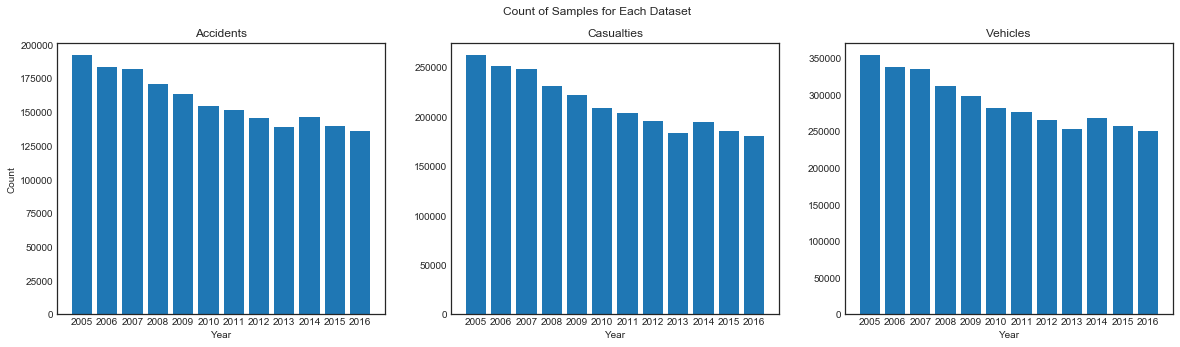

In [42]:
fig = plt.figure(figsize=[20, 5])
ind = 131

ax = fig.add_subplot(ind)
x, y = simple_line_numeric(acc["Year"].unique(), list(acc.groupby("Year").count()["Accident_Index"]))
ax.bar(x, y)
ax.set_ylabel("Count")
ax.set_xlabel("Year")
ax.set_xticks(sorted(acc["Year"].unique()))
ax.set_title("Accidents")
ind += 1

ax = fig.add_subplot(ind)
x, y = simple_line_numeric(acc["Year"].unique(), 
                           list(cas.merge(acc[["Accident_Index", "Year"]], how="left").groupby("Year").count()["Accident_Index"]))
ax.bar(x, y)
ax.set_xlabel("Year")
ax.set_xticks(sorted(acc["Year"].unique()))
ax.set_title("Casualties")
ind += 1

ax = fig.add_subplot(ind)
x, y = simple_line_numeric(acc["Year"].unique(), 
                           list(veh.merge(acc[["Accident_Index", "Year"]], how="left").groupby("Year").count()["Accident_Index"]))
ax.bar(x, y)
ax.set_xlabel("Year")
ax.set_xticks(sorted(acc["Year"].unique()))
ax.set_title("Vehicles")
ind += 1

fig.suptitle("Count of Samples for Each Dataset")
plt.show()

D:\Anaconda3\envs\FYP_TAP_ENV\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


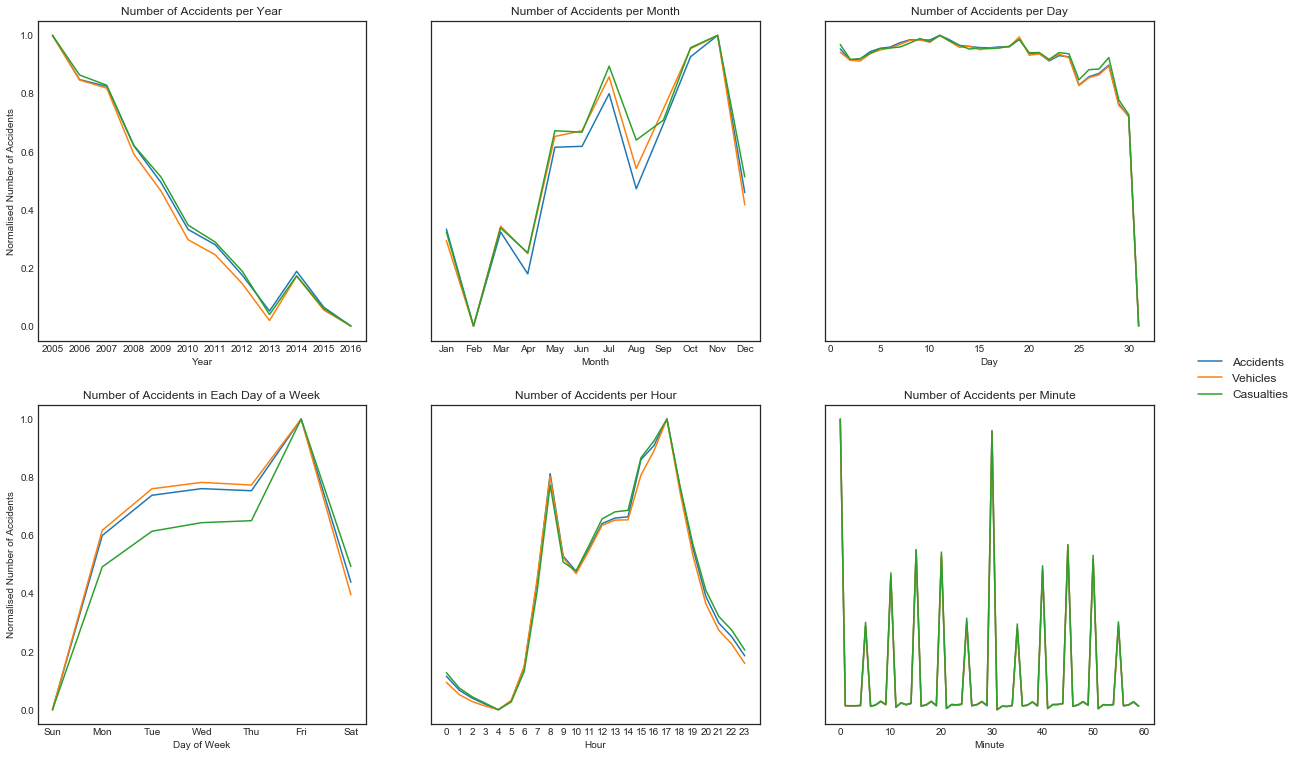

In [43]:
veh_ind = pd.DataFrame({
    'Accident_Index': veh['Accident_Index']
}).merge(acc.loc[:, ('Accident_Index', 'Date_Time', 'Day_of_Week')], on = 'Accident_Index', how = 'inner')
cas_ind = pd.DataFrame({
    'Accident_Index': cas['Accident_Index']
}).merge(acc.loc[:, ('Accident_Index', 'Date_Time', 'Day_of_Week')], on = 'Accident_Index', how = 'inner')
hold = 'Accident_Index'
dtm = 'Date_Time'

fig = plt.figure(figsize=[20,20])
# fig.set_facecolor("white")
nrow, ncol, ind = 3, 3, 1

# Year
ax = fig.add_subplot(nrow, ncol, ind)
dt_general_plotter(ax, acc[hold], acc[dtm].dt.year, 'Accidents', min_max_scaler)
dt_general_plotter(ax, veh_ind[hold], veh_ind[dtm].dt.year, 'Vehicles', min_max_scaler)
dt_general_plotter(ax, cas_ind[hold], cas_ind[dtm].dt.year, 'Casualties', min_max_scaler)
ax.set_xticks(acc[dtm].dt.year.unique())
ax.set_xlabel("Year")
ax.set_ylabel("Normalised Number of Accidents")
ax.set_title('Number of Accidents per Year')
ind += 1

# Month
ax = fig.add_subplot(nrow, ncol, ind)
dt_general_plotter(ax, acc[hold], acc[dtm].dt.month, 'Accidents', min_max_scaler)
dt_general_plotter(ax, veh_ind[hold], veh_ind[dtm].dt.month, 'Vehicles', min_max_scaler)
dt_general_plotter(ax, cas_ind[hold], cas_ind[dtm].dt.month, 'Casualties', min_max_scaler)
ax.set_xticks(acc[dtm].dt.month.unique())
ax.set_xlabel("Month")
ax.set_xticks(sorted(acc["Month"].unique()))
ax.set_xticklabels([month_mapping[m] for m in sorted(acc["Month"].unique())])
ax.set_title('Number of Accidents per Month')
ax.set_yticks([])
ind += 1

# Day
ax = fig.add_subplot(nrow, ncol, ind)
dt_general_plotter(ax, acc[hold], acc[dtm].dt.day, 'Accidents', min_max_scaler)
dt_general_plotter(ax, veh_ind[hold], veh_ind[dtm].dt.day, 'Vehicles', min_max_scaler)
dt_general_plotter(ax, cas_ind[hold], cas_ind[dtm].dt.day, 'Casualties', min_max_scaler)
ax.set_title('Number of Accidents per Day')
ax.set_xlabel("Day")
ax.set_yticks([])
ind += 1

ax = fig.add_subplot(nrow, ncol, ind)
dt_general_plotter(ax, acc[hold], acc["Day_of_Week"], 'Accidents', min_max_scaler)
dt_general_plotter(ax, veh_ind[hold], veh_ind["Day_of_Week"], 'Vehicles', min_max_scaler)
dt_general_plotter(ax, cas_ind[hold], cas_ind["Day_of_Week"], 'Casualties', min_max_scaler)
ax.set_title('Number of Accidents in Each Day of a Week')
ax.set_xlabel("Day of Week")
ax.set_xticks(sorted(acc["Day_of_Week"].unique()))
ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax.set_ylabel("Normalised Number of Accidents")
ind += 1

# Hour
ax = fig.add_subplot(nrow, ncol, ind)
dt_general_plotter(ax, acc[hold], acc[dtm].dt.hour, 'Accidents', min_max_scaler)
dt_general_plotter(ax, veh_ind[hold], veh_ind[dtm].dt.hour, 'Vehicles', min_max_scaler)
dt_general_plotter(ax, cas_ind[hold], cas_ind[dtm].dt.hour, 'Casualties', min_max_scaler)
ax.set_xticks(acc[dtm].dt.hour.unique())
ax.set_xlabel("Hour")
ax.set_yticks([])
ax.set_title('Number of Accidents per Hour')
ind += 1

# Minute
ax = fig.add_subplot(nrow, ncol, ind)
l1, = dt_general_plotter(ax, acc[hold], acc[dtm].dt.minute, 'Accidents', min_max_scaler)
l2, = dt_general_plotter(ax, veh_ind[hold], veh_ind[dtm].dt.minute, 'Vehicles', min_max_scaler)
l3, = dt_general_plotter(ax, cas_ind[hold], cas_ind[dtm].dt.minute, 'Casualties', min_max_scaler)
ax.set_title('Number of Accidents per Minute')
ax.set_xlabel("Minute")
ax.set_yticks([])
ind += 1

fig.legend([l1, l2, l3], ["Accidents", "Vehicles", "Casualties"], loc="center right", fancybox=True, fontsize="large")
plt.show()

No handles with labels found to put in legend.


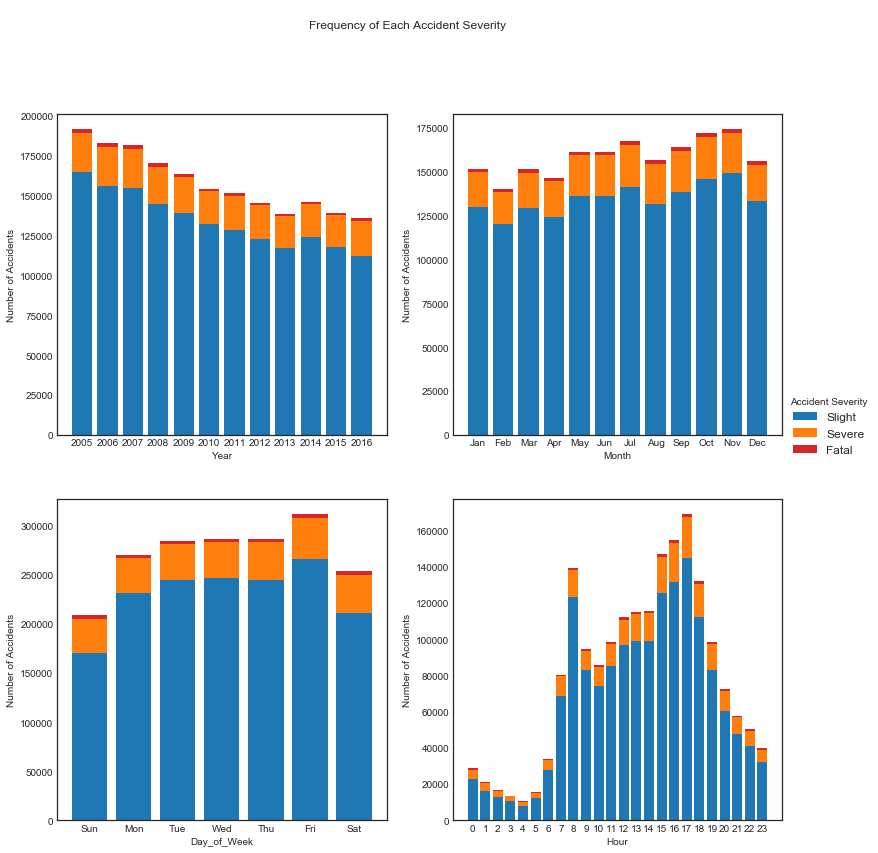

In [44]:
fig = plt.figure(figsize=[13, 13])
fig.legend()
ind = 221
leg = list()
for c in ["Year", "Month", "Day_of_Week", "Hour"]:
    ax = fig.add_subplot(ind)
    leg = plot_stacked_bar_severity(acc, c, ax)
    ind += 1

fig.suptitle("Frequency of Each Accident Severity")
fig.legend(leg, ["Slight", "Severe", "Fatal"], loc="center right", fancybox=True, fontsize="large", title="Accident Severity")
plt.show()

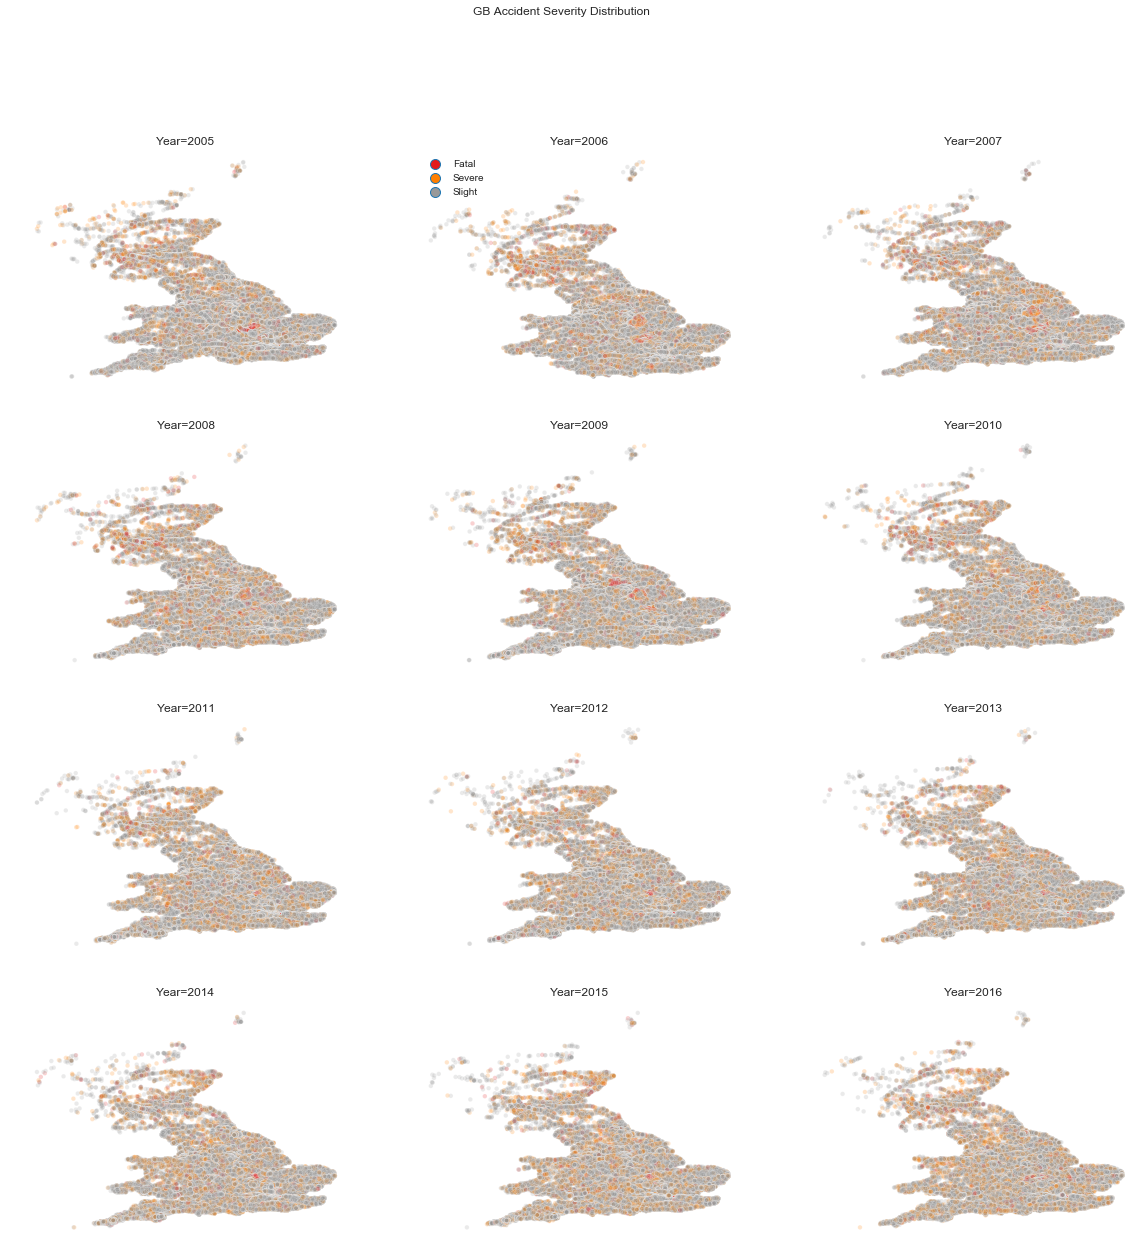

In [13]:
fig = plt.figure(figsize=[20, 20])
years = sorted(acc["Year"].unique())
ncol, ind = 3, 1
nrow = int(np.round(len(years)/ncol))

fig.suptitle("GB Accident Severity Distribution")
for yr in years:
    geodata = to_geodf(acc[acc["Year"] == yr])
    ax = fig.add_subplot(nrow, ncol, ind)
    ax.set_title("Year=" + str(yr))
    ax = gplt.pointplot(geodata, alpha=0.2, hue='Accident_Severity', categorical=True, legend_labels=["Fatal", "Severe", "Slight"],
                   legend=False if yr != 2006 else True, edgecolor='white', linewidth=0.5, legend_kwargs={'loc': 'upper left'}, ax=ax)
    ind += 1

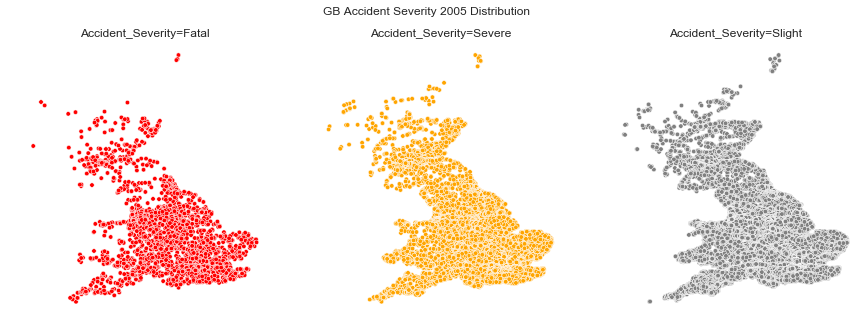

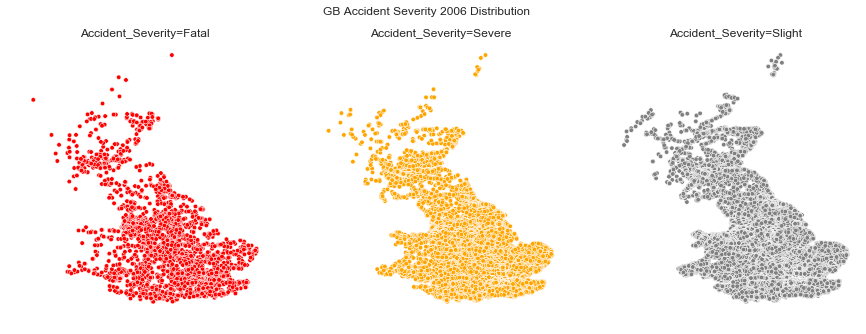

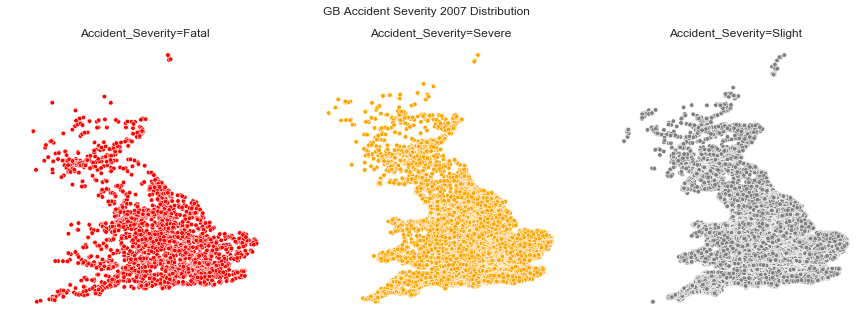

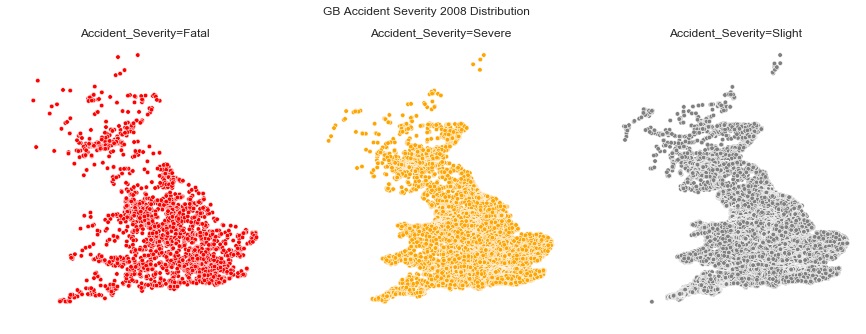

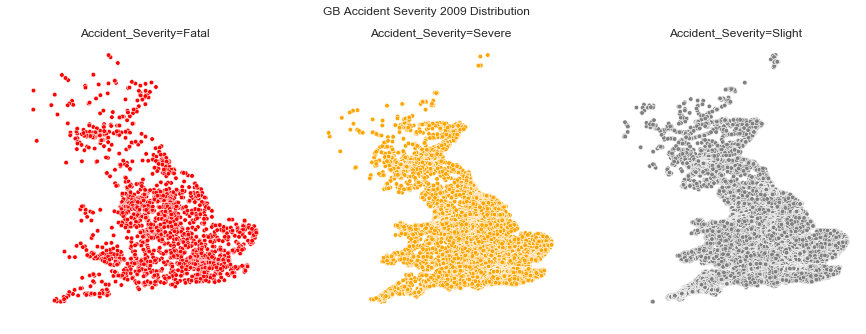

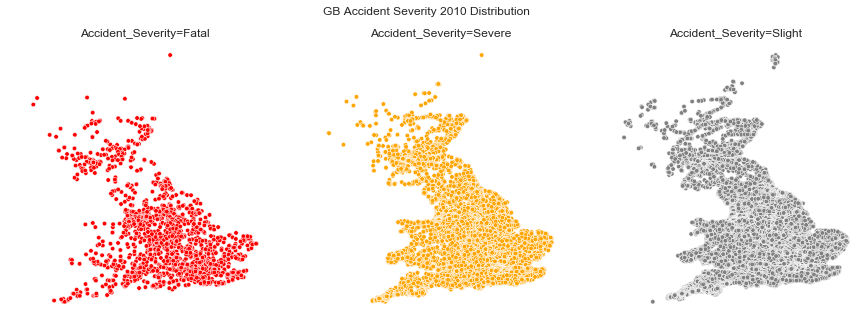

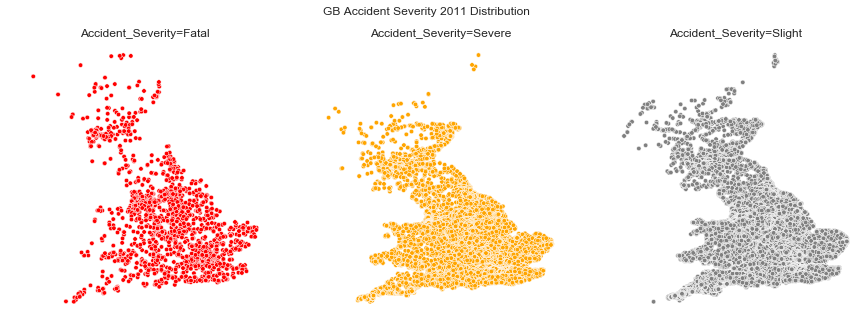

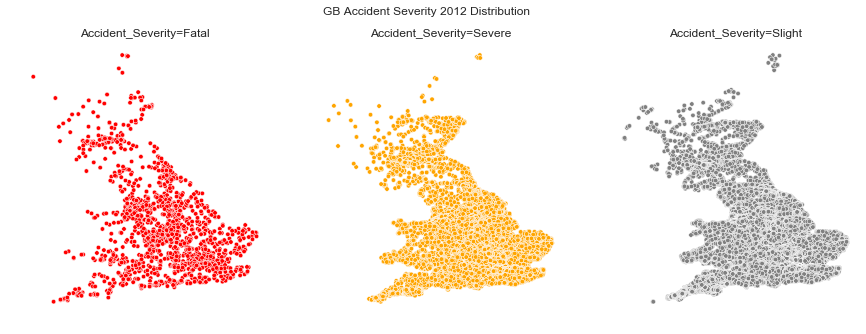

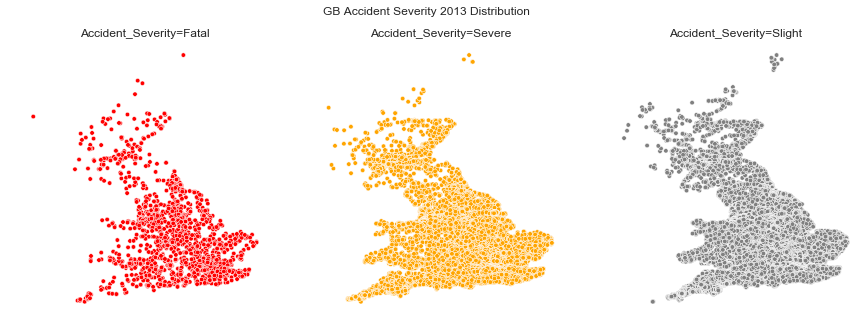

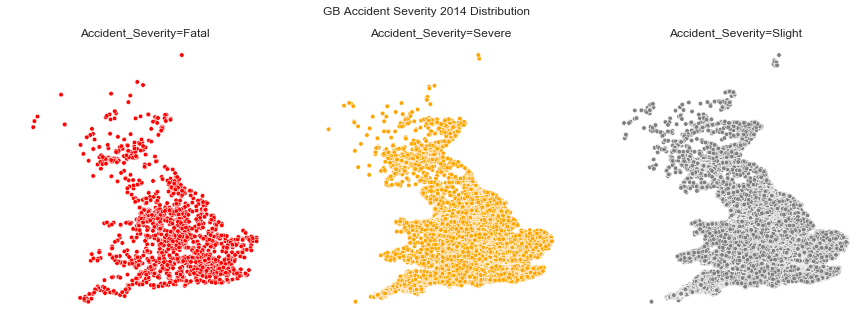

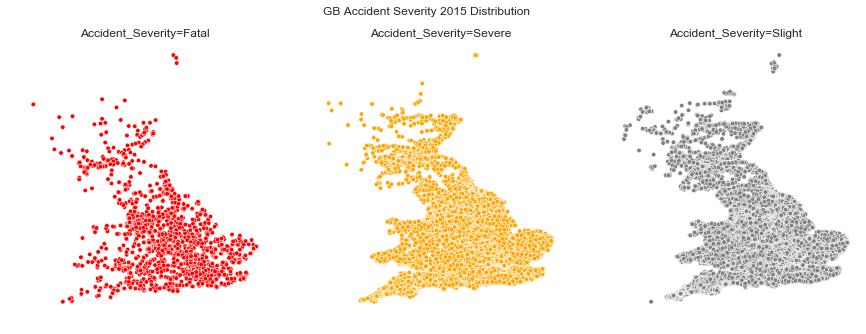

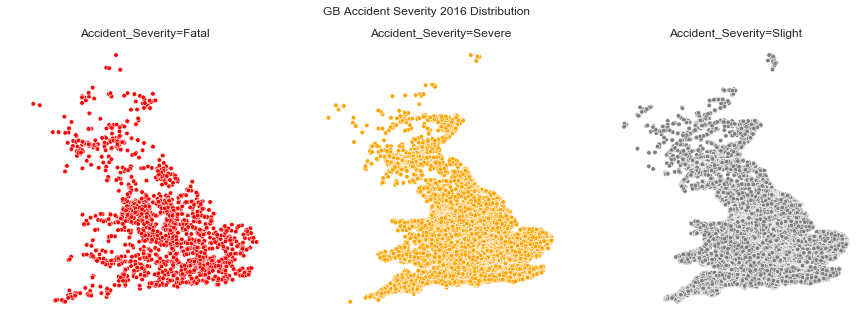

In [14]:
tas = sorted(acc["Accident_Severity"].unique())
yrs = sorted(acc["Year"].unique())
colors = {
    1: "red",
    2: "orange",
    3: "grey"
}

for yr in yrs:
    fig = plt.figure(figsize=[15, 5])
    fig.suptitle("GB Accident Severity " + str(yr) + " Distribution")
    ind = 131
    tmp = acc[acc["Year"] == yr]
    for t in tas:
        geodata = to_geodf(tmp[tmp["Accident_Severity"] == t])
        ax = fig.add_subplot(ind)
        ax.set_title("Accident_Severity=" + accident_severity_mapping[t])
        ax = gplt.pointplot(geodata, edgecolor='white', linewidth=0.5, ax=ax, color=colors[t])
        ind += 1

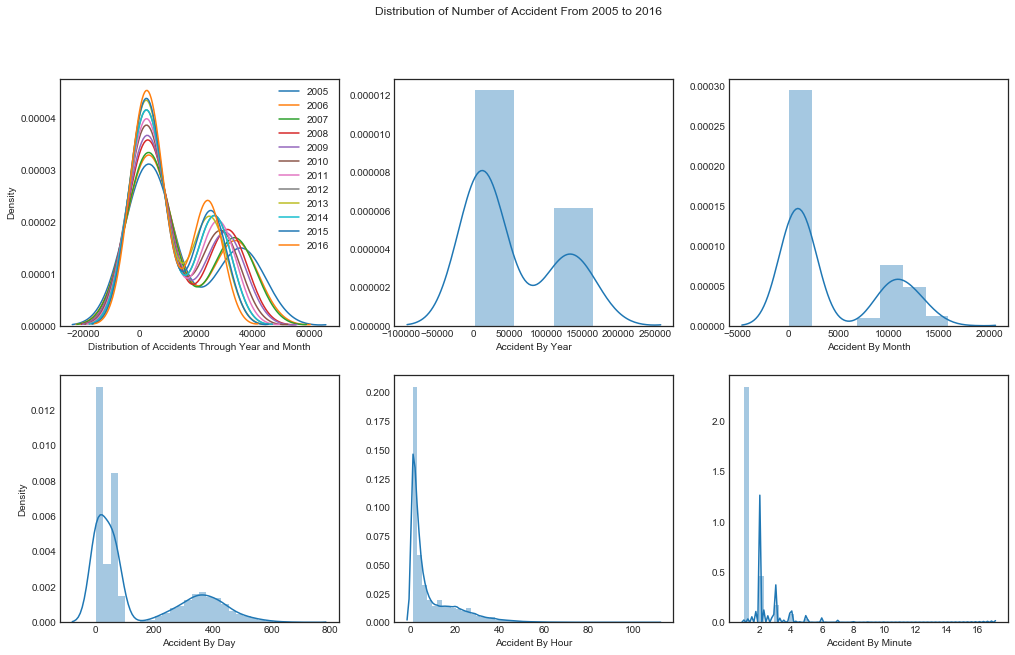

In [45]:
tmp = acc.merge(veh, on='Accident_Index').merge(cas, on='Accident_Index').groupby(
    ['Year', 'Month', 'Accident_Severity']).count()['Accident_Index']
ind = 231
fig = plt.figure(figsize=[17, 10])
fig.suptitle("Distribution of Number of Accident From 2005 to 2016")
ax = fig.add_subplot(ind)
for yr in pd.unique(acc['Year']):
    sns.kdeplot(tmp[yr], label=str(yr), ax=ax)
ax.set_xlabel("Distribution of Accidents Through Year and Month")
ax.set_ylabel("Density")
ind += 1
ax = fig.add_subplot(ind)
sns.distplot(acc.groupby(['Year', acc['Accident_Severity']]).count()['Accident_Index'].astype("int64"), axlabel='Accident By Year', ax=ax)
ind += 1
ax = fig.add_subplot(ind)
sns.distplot(acc.groupby(['Year', 'Month', acc['Accident_Severity']]).count()['Accident_Index'].astype("int64"), axlabel='Accident By Month', ax=ax)
ind += 1
ax = fig.add_subplot(ind)
sns.distplot(acc.groupby(['Year', 'Month', acc['Date_Time'].dt.day, acc['Accident_Severity']]).count()['Accident_Index'].fillna(0).astype("int64"), axlabel='Accident By Day', ax=ax)
ax.set_ylabel("Density")
ind += 1
ax = fig.add_subplot(ind)
sns.distplot(acc.groupby(['Year', 'Month', acc['Date_Time'].dt.day, acc['Date_Time'].dt.hour, acc['Accident_Severity']]).count()['Accident_Index'].fillna(0).astype("int64"), axlabel='Accident By Hour', ax=ax)
ind += 1
ax = fig.add_subplot(ind)
sns.distplot(acc.groupby(['Year', 'Month', acc['Date_Time'].dt.day, acc['Date_Time'].dt.hour, acc['Date_Time'].dt.minute, acc['Accident_Severity']]).count()['Accident_Index'].fillna(0).astype("int64"), axlabel='Accident By Minute', ax=ax)
plt.show()

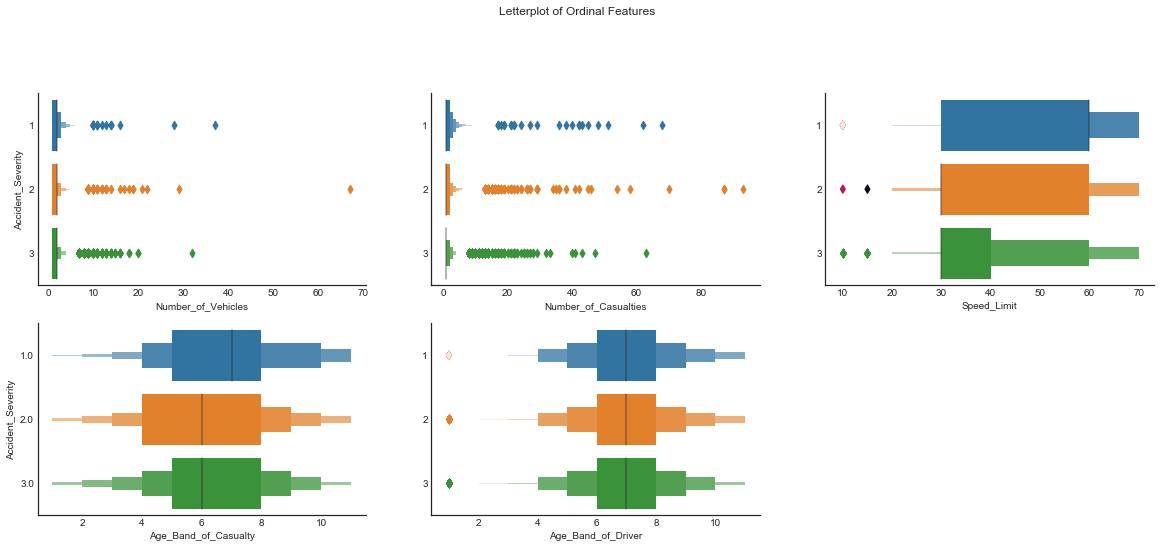

In [46]:
fig = plt.figure(figsize=[20, 12])
nrow, ncol, ind = 3, 3, 1
ind = plot_lv_relation_with(data = acc[acc.columns[acc.columns.isin(ordinal)]], 
                            fig = fig, dv = 'Accident_Severity', orient = 'h', ncol = ncol, nrow = nrow, ind = ind)
tmp = cas.merge(acc[["Accident_Index", "Accident_Severity"]], how="left")
ind = plot_lv_relation_with(data = tmp[tmp.columns[tmp.columns.isin(ordinal)]], 
                            fig = fig, dv = 'Accident_Severity', orient = 'h', ncol = ncol, nrow = nrow, ind = ind)
tmp = veh.merge(acc[["Accident_Index", "Accident_Severity"]], how="left")
ind = plot_lv_relation_with(data = tmp[tmp.columns[tmp.columns.isin(ordinal)]], 
                            fig = fig, dv = 'Accident_Severity', orient = 'h', ncol = ncol, nrow = nrow, ind = ind)
fig.suptitle("Letterplot of Ordinal Features")
plt.show()
del tmp

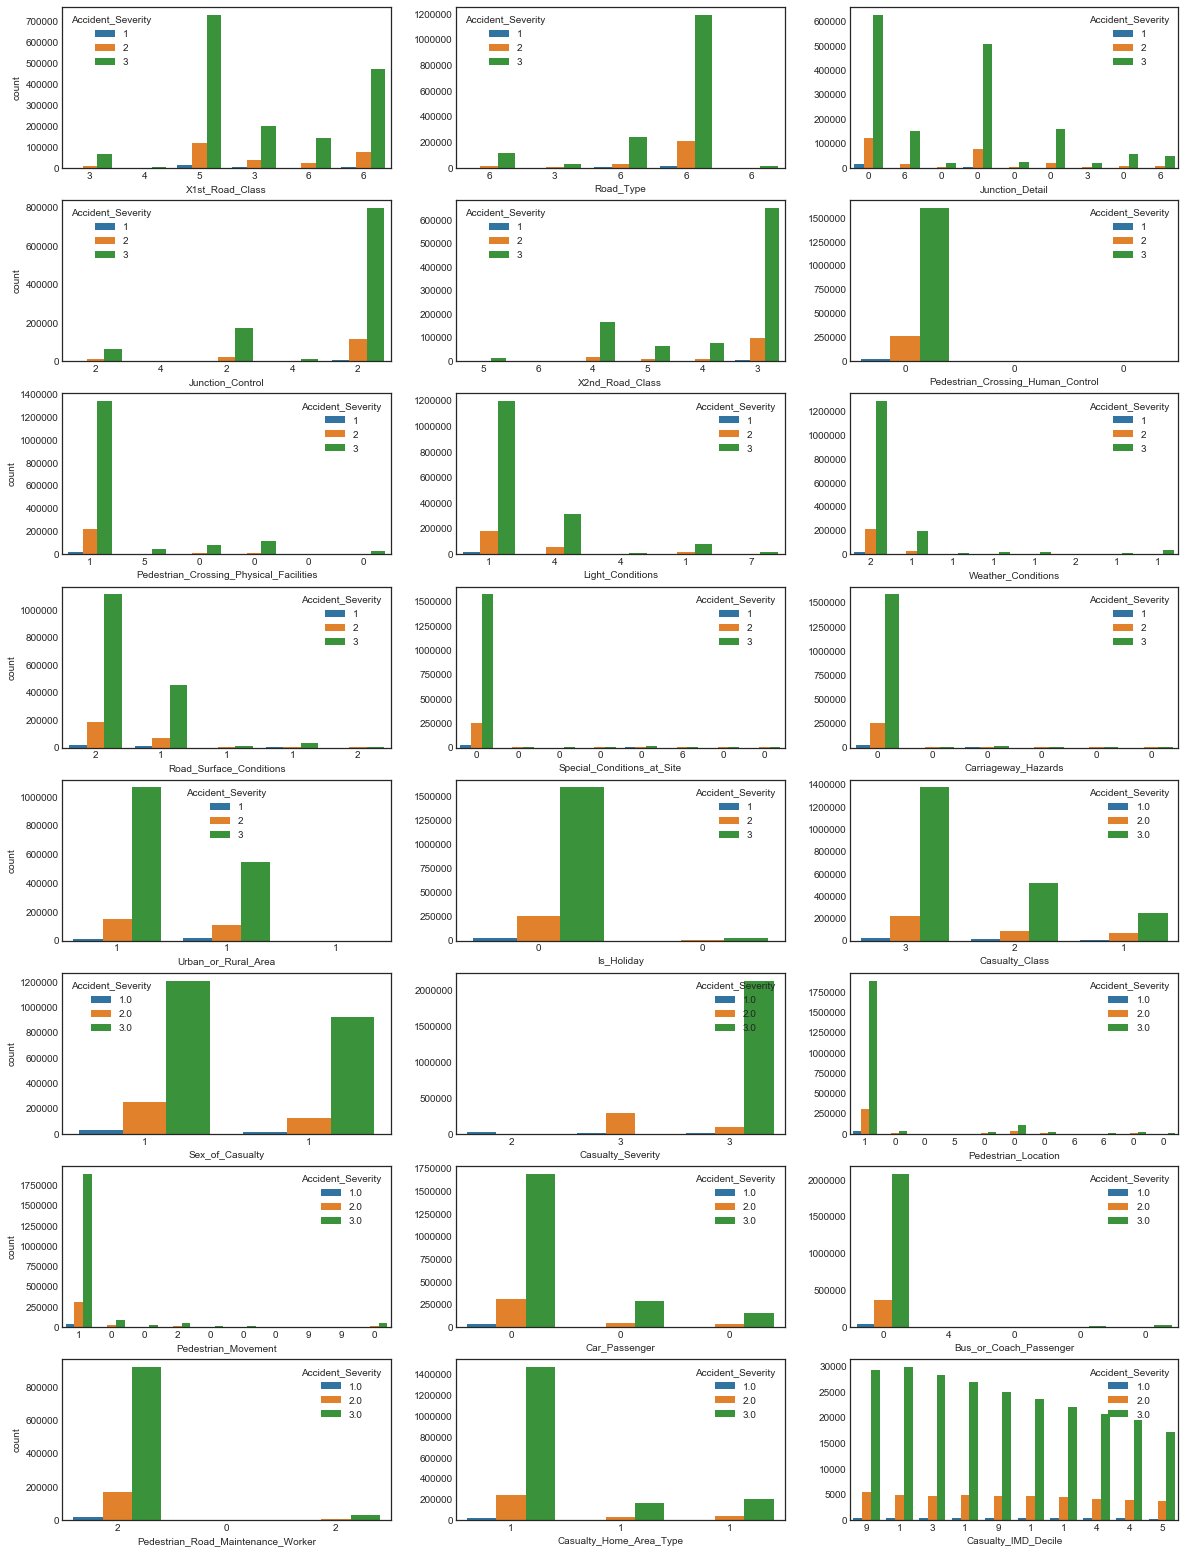

In [47]:
fig = plt.figure(figsize=[20, 170])
nrow = len(acccat) + len(vehcat) + len(cascat)
ind = count_all(acc, acccat, hue="Accident_Severity", fig=fig, nrow=nrow)
ind = count_all(cas.merge(acc[["Accident_Index", "Accident_Severity"]], how="left"), cascat, hue="Accident_Severity", fig=fig, nrow=nrow, ind=ind)
ind = count_all(veh.merge(acc[["Accident_Index", "Accident_Severity"]], how="left"), cascat, hue="Accident_Severity", fig=fig, nrow=nrow, ind=ind)

In [18]:
###############END######################

## Missing data

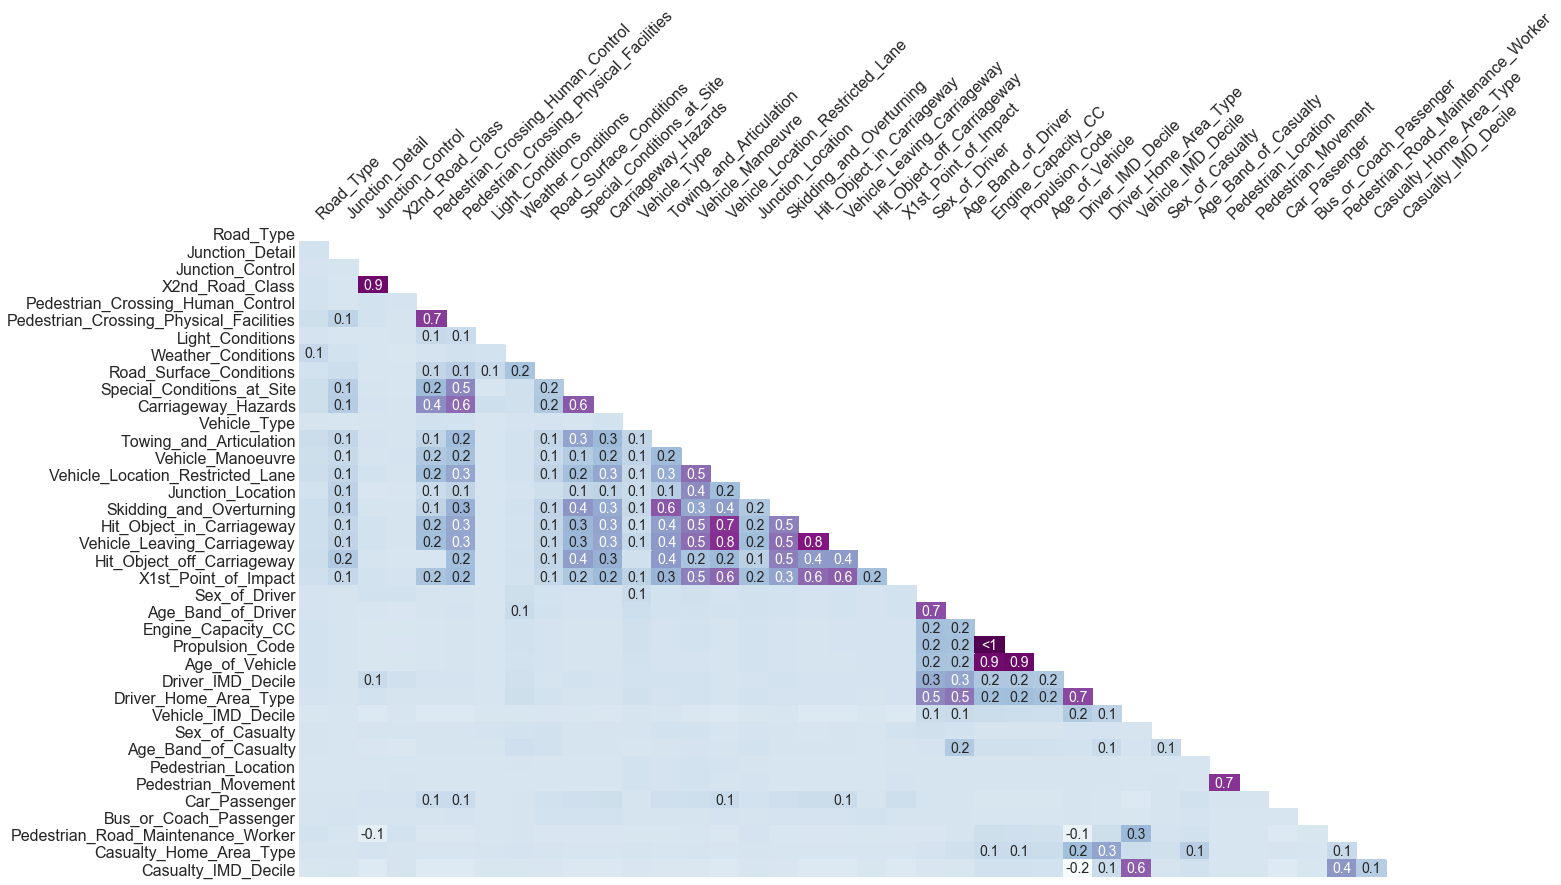

In [19]:
msno.heatmap(auto_drop(acc.merge(veh, on='Accident_Index', how='inner').merge(cas, on='Accident_Index', how='inner')), cmap='BuPu')

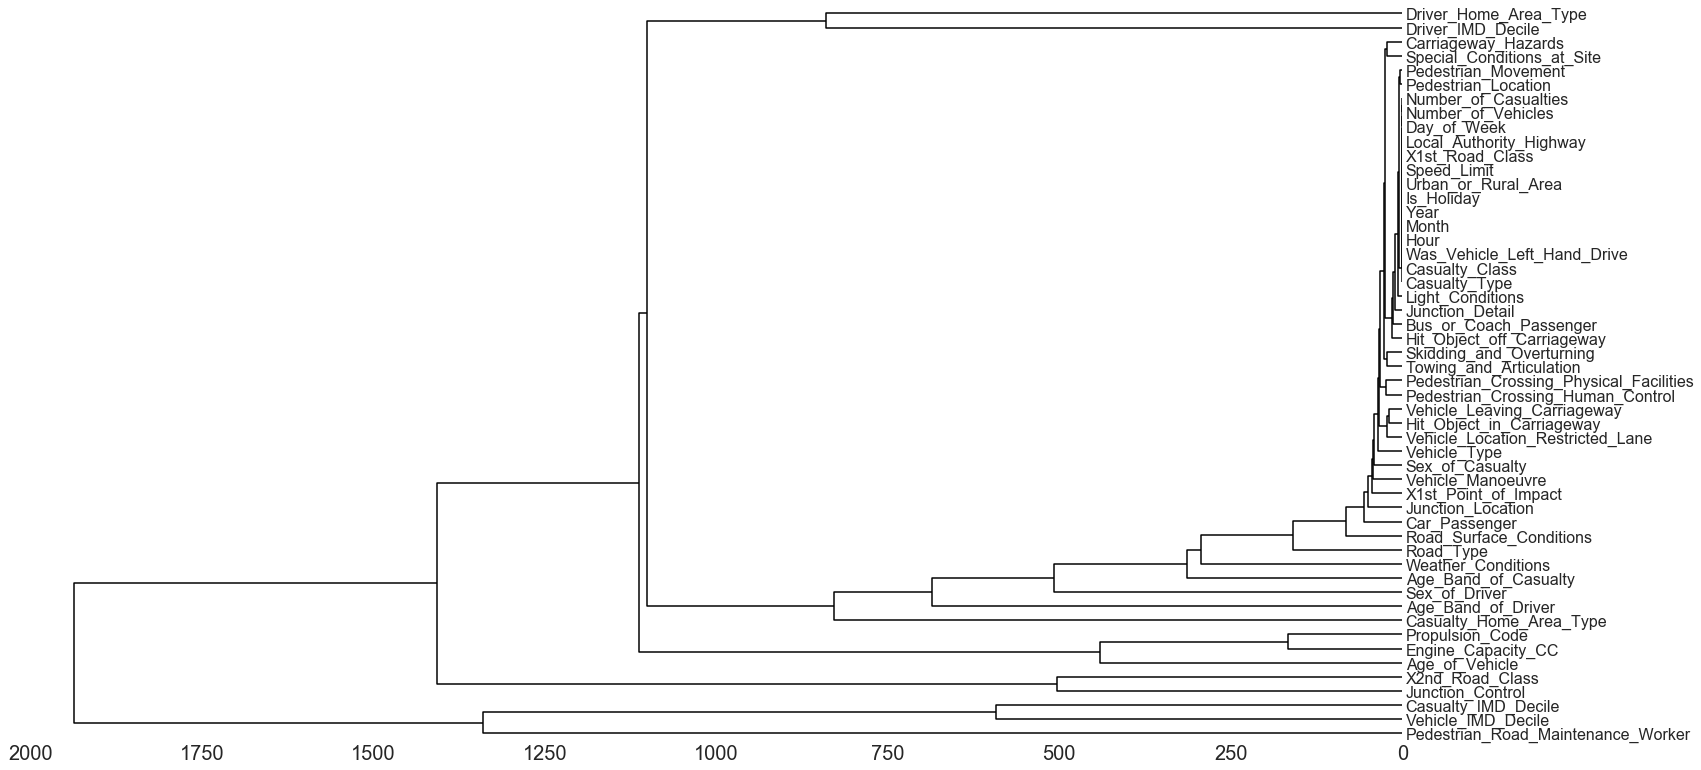

In [20]:
msno.dendrogram(auto_drop(acc.merge(veh, on = 'Accident_Index', how = 'inner').merge(cas, on='Accident_Index', how='inner')))

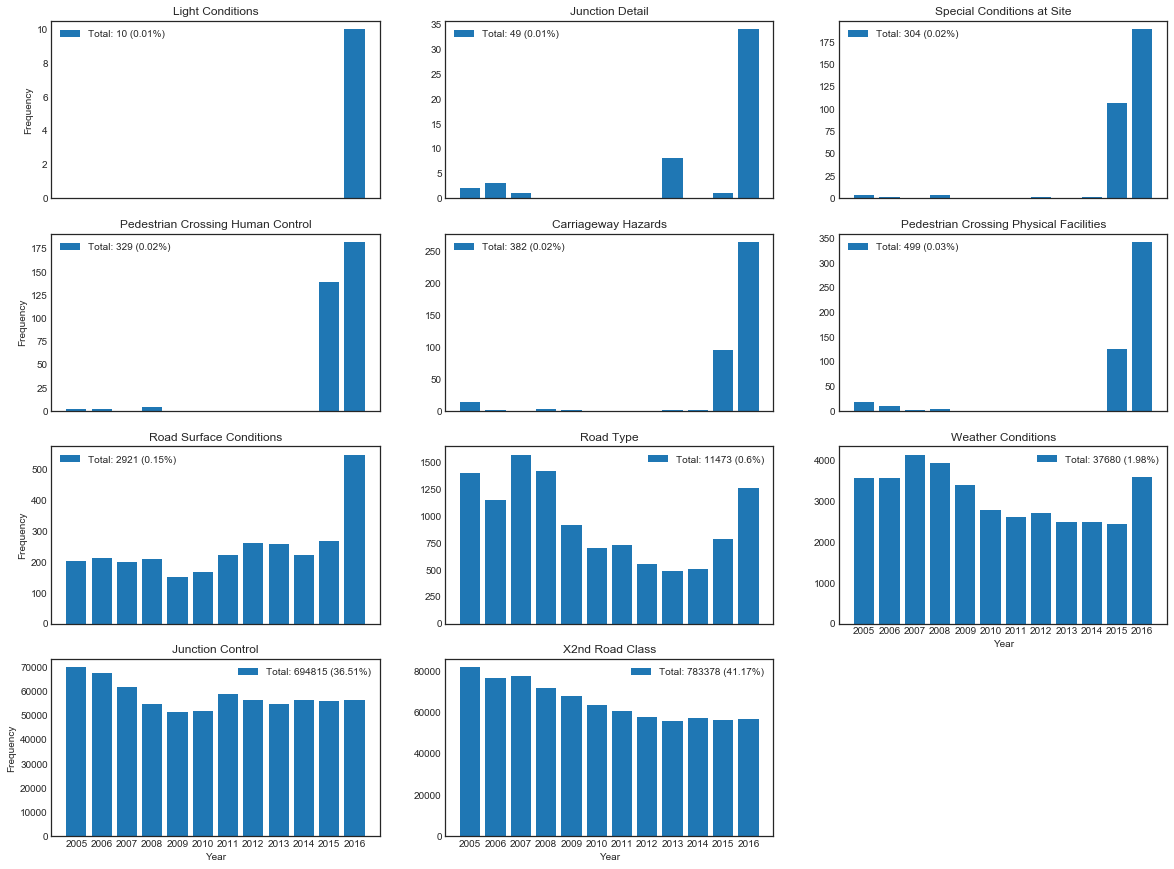

In [48]:
# How many are missing each year? Maybe survey is different by year
plot_yearly_missing_data_cols(data = auto_drop(acc), fig = plt.figure(figsize=[20,15]))
plt.show()

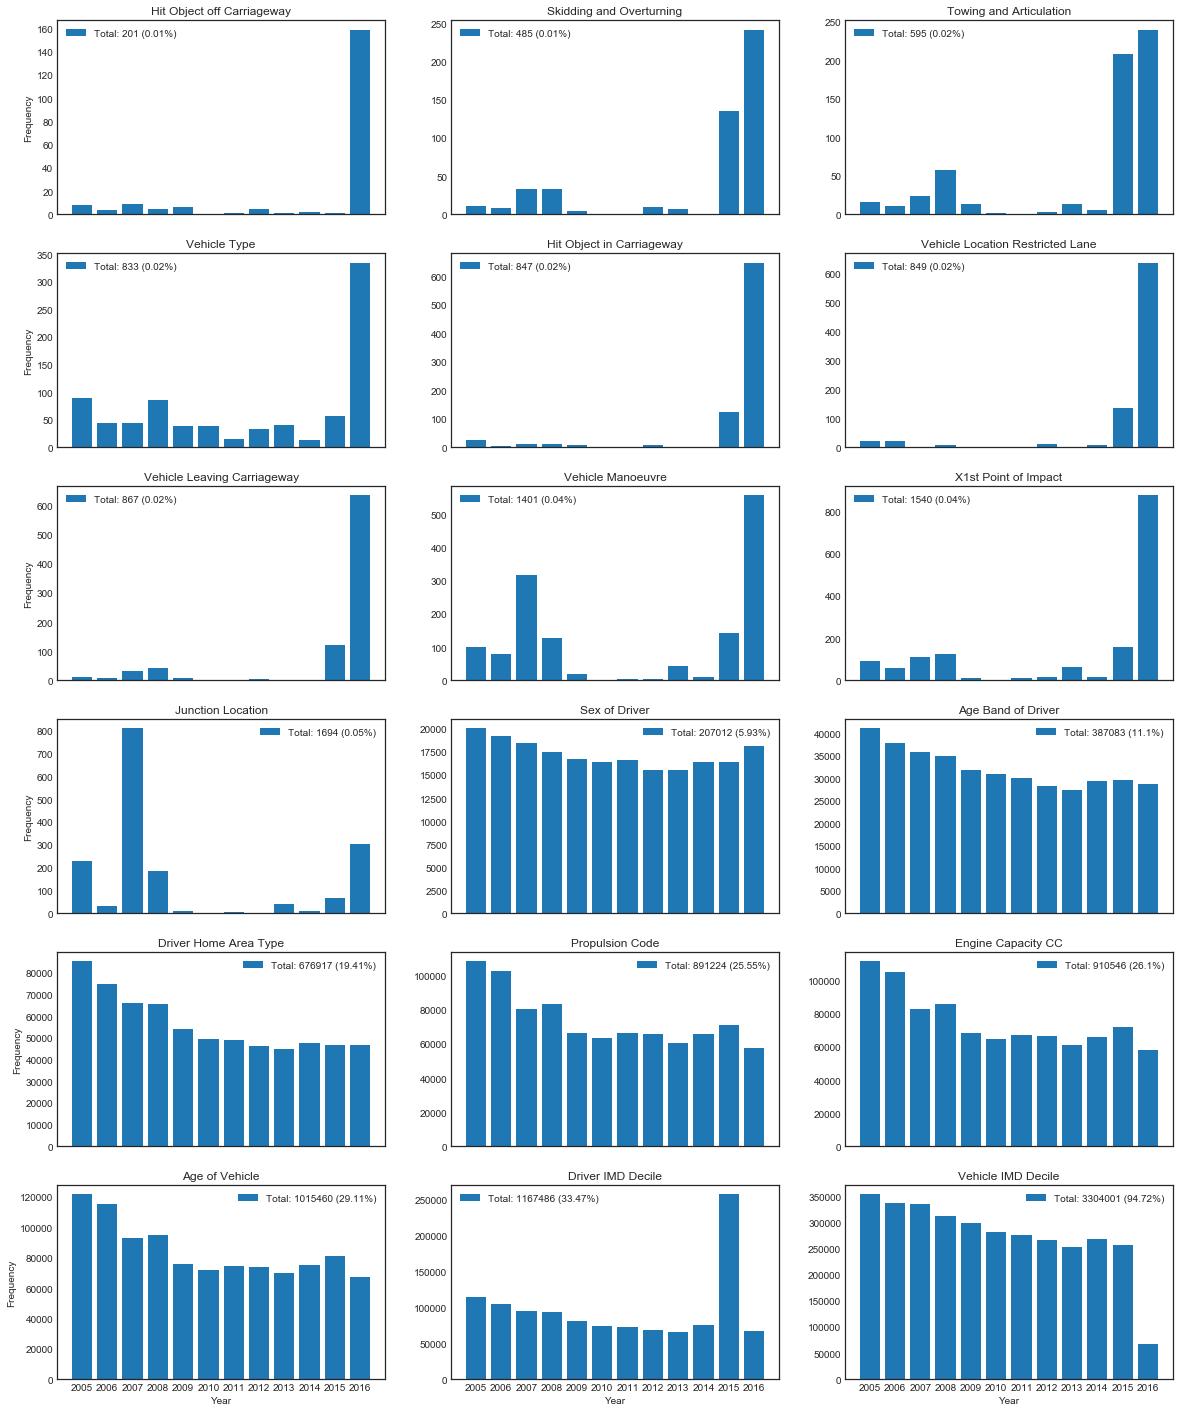

In [49]:
plot_yearly_missing_data_cols(data = auto_drop(veh.merge(acc.loc[:, ('Accident_Index', 'Year')], how = 'left')), 
                              fig = plt.figure(figsize=[20, 25]))
plt.show()

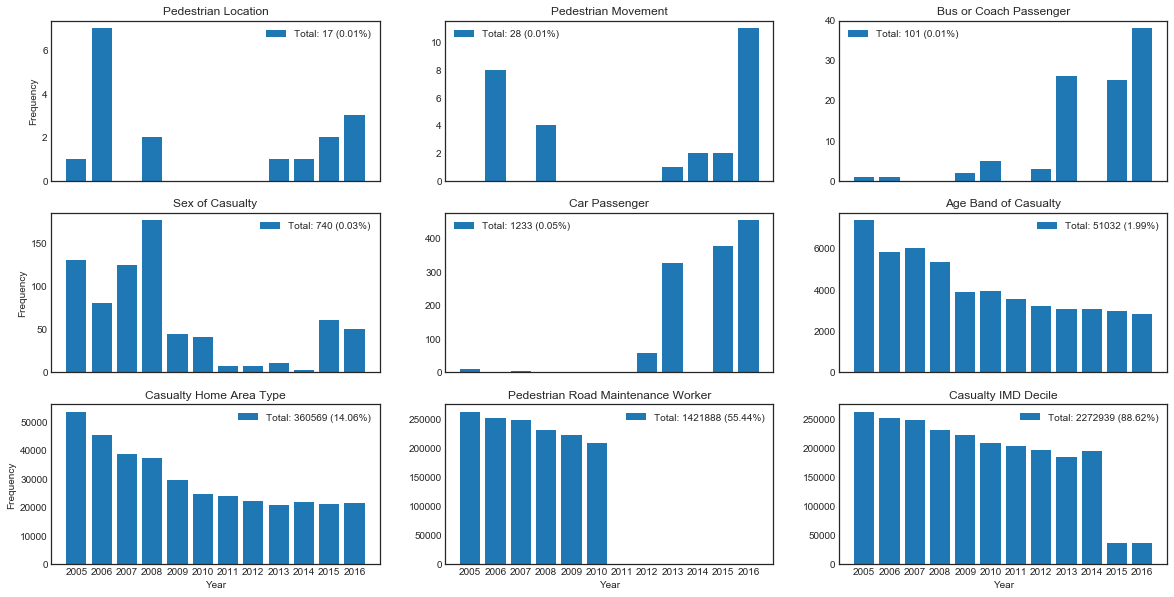

In [50]:
plot_yearly_missing_data_cols(data = auto_drop(cas.merge(acc.loc[:, ('Accident_Index', 'Year')], on = 'Accident_Index', how = 'inner')), 
                              fig = plt.figure(figsize=[20, 10]))
plt.show()

In [24]:
###############END######################

# Analysis 2

In [52]:
# import data
iacc = pd.read_csv("./" + dirs["imp"] + "acc2005_2015-v2018.2.5.imp.csv").merge(acc[["Accident_Index", "Number_of_Casualties", "Local_Authority_Highway"]], how="left")
iveh = pd.read_csv("./" + dirs["imp"] + "veh2005_2015-v2018.2.5.imp.csv")
icas = pd.read_csv("./" + dirs["imp"] + "cas2005_2015-v2018.2.5.imp.csv")

## General

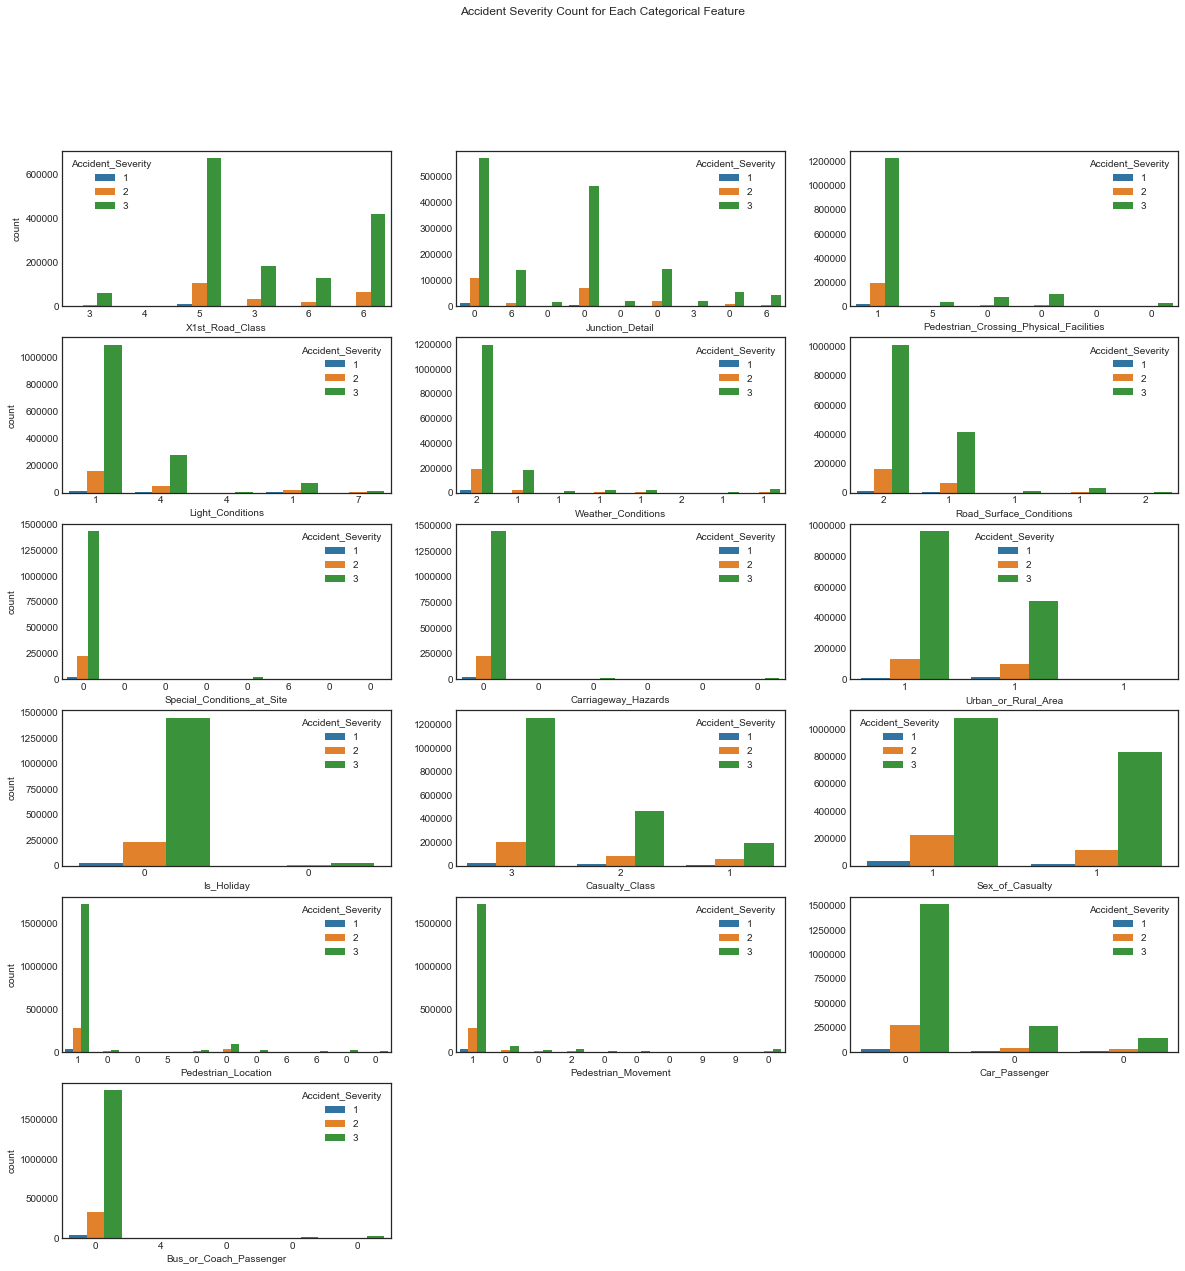

In [53]:
fig = plt.figure(figsize=[20, 20])
fig.suptitle("Accident Severity Count for Each Categorical Feature")
nrow = 6
ind = count_all(iacc, acccat, hue="Accident_Severity", fig=fig, nrow=nrow)
ind = count_all(icas.merge(iacc[["Accident_Index", "Accident_Severity"]], how="left"), cascat, hue="Accident_Severity", fig=fig, nrow=nrow, ind=ind)
ind = count_all(iveh.merge(iacc[["Accident_Index", "Accident_Severity"]], how="left"), cascat, hue="Accident_Severity", fig=fig, nrow=nrow, ind=ind)

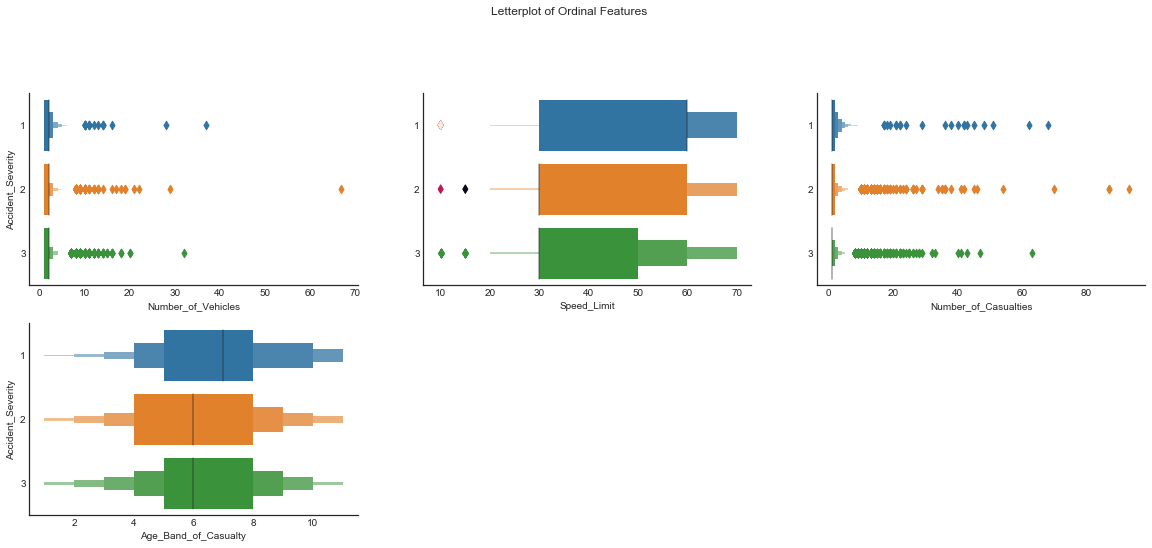

In [54]:
fig = plt.figure(figsize=[20, 12])
nrow, ncol, ind = 3, 3, 1
ind = plot_lv_relation_with(data = iacc[iacc.columns[iacc.columns.isin(ordinal)]], 
                            fig = fig, dv = 'Accident_Severity', orient = 'h', ncol = ncol, nrow = nrow, ind = ind)
tmp = icas.merge(iacc[["Accident_Index", "Accident_Severity"]], how="left")
ind = plot_lv_relation_with(data = tmp[tmp.columns[tmp.columns.isin(ordinal)]], 
                            fig = fig, dv = 'Accident_Severity', orient = 'h', ncol = ncol, nrow = nrow, ind = ind)
tmp = iveh.merge(iacc[["Accident_Index", "Accident_Severity"]], how="left")
ind = plot_lv_relation_with(data = tmp[tmp.columns[tmp.columns.isin(ordinal)]], 
                            fig = fig, dv = 'Accident_Severity', orient = 'h', ncol = ncol, nrow = nrow, ind = ind)
fig.suptitle("Letterplot of Ordinal Features")
plt.show()
del tmp

In [28]:
##############END########################

## Feature Selection

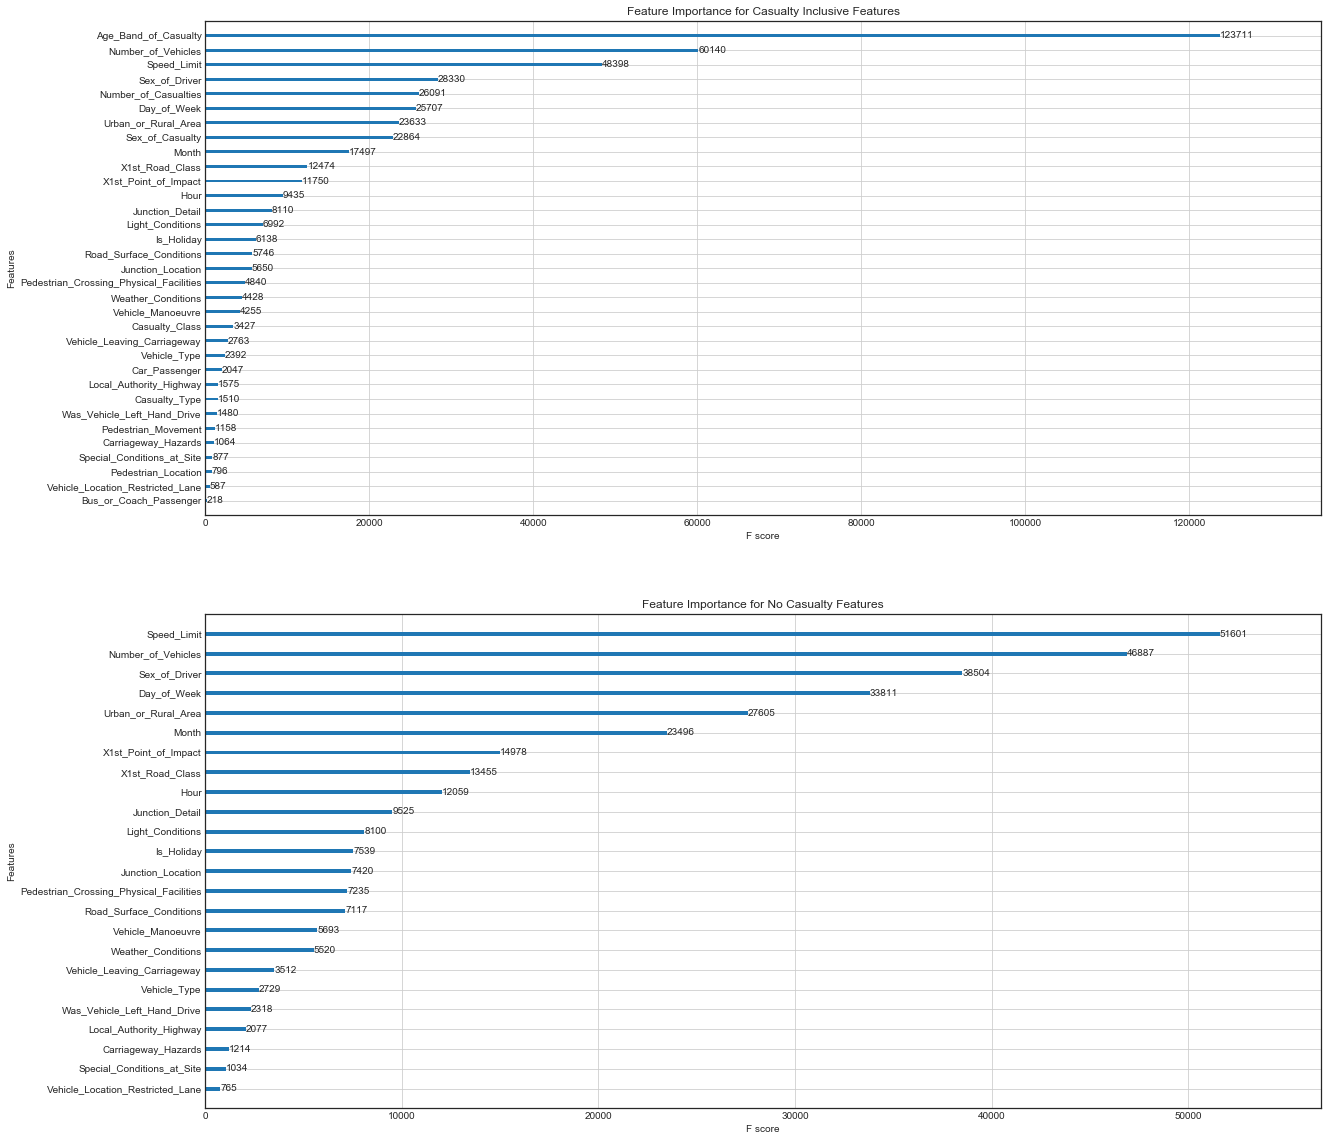

In [55]:
tmp = joblib.load("./plots/xgb_feature_importance.cas.pkl.xz")
f = dict()
for k, v in tmp.items():
    f[k] = int(np.round(v))
fig = plt.figure(figsize=[20, 20])

ax = fig.add_subplot(211)
xgb.plot_importance(f, ax=ax, title="Feature Importance for Casualty Inclusive Features")

tmp = joblib.load("./plots/xgb_feature_importance.nocas.pkl.xz")
f = dict()
for k, v in tmp["xgtf"].items():
    f[k] = int(np.round(v))

ax = fig.add_subplot(212)
xgb.plot_importance(f, ax=ax, title="Feature Importance for No Casualty Features")

plt.show()

del f, tmp

## Modelling

In [57]:
# import model use data
tap = iacc.merge(icas, on="Accident_Index", how="inner").merge(iveh, on="Accident_Index", how="inner")
all_train_columns = np.invert(tap.columns.isin([
    'Accident_Index', 'Accident_Severity', 'Date_Time', 'Year'
]))
freq_columns = ['Number_of_Vehicles', 'Speed_Limit', 'Age_Band_of_Casualty', 'Number_of_Casualties']
cat_columns = tap.columns[all_train_columns].drop(freq_columns)
cas_columns = ['Casualty_Class', 'Pedestrian_Location', 'Pedestrian_Movement', 'Car_Passenger', 'Bus_or_Coach_Passenger', 'Casualty_Type', 'Sex_of_Casualty', 'Age_Band_of_Casualty', 'Number_of_Casualties']

## Analysis

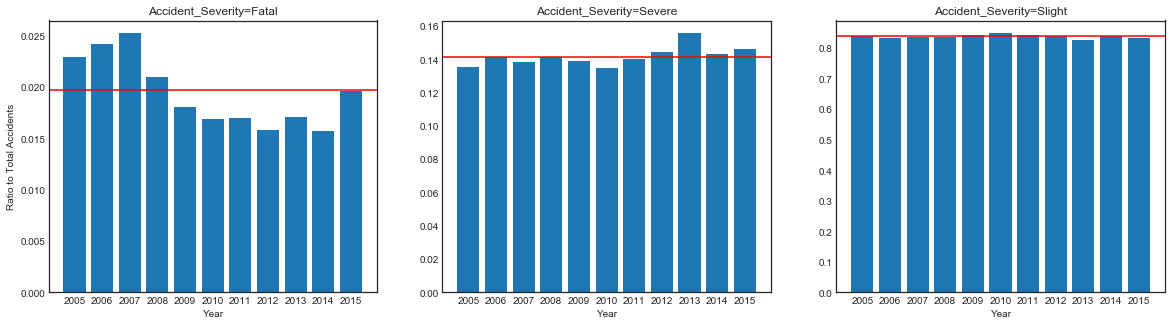

In [58]:
baseline_ratio = np.divide(tap["Accident_Severity"].value_counts(), tap["Accident_Severity"].value_counts().sum())
every_year_num_of_acc = tap.groupby("Year").count()["Accident_Index"]
ratio_store = OrderedDict([
    (sev, []) for sev in sorted(pd.unique(tap["Accident_Severity"]))
])
for sev, _ in ratio_store.items():
    severity_count = tap[tap["Accident_Severity"] == sev].groupby("Year").count()["Accident_Index"]
    ratio_store[sev] = np.divide(severity_count, every_year_num_of_acc)

fig = plt.figure(figsize=[20,5])
ind = 131

for sev, ratio in ratio_store.items():
    ax = fig.add_subplot(ind)
    ax.bar(sorted(pd.unique(tap["Year"])), ratio)
    ax.axhline(baseline_ratio[sev], color="red")
    ax.set_title("Accident_Severity=" + accident_severity_mapping[sev])
    ax.set_xticks(sorted(pd.unique(tap["Year"])))
    ax.set_xlabel("Year")
    if ind == 131:
        ax.set_ylabel("Ratio to Total Accidents")
    ind += 1

In [59]:
sampled = joblib.load("test/stratified_traintest.pkl.xz")
ignore_cols = ['Accident_Index', 'Date_Time', 'Year']
sel_cols = ['Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties']
# Only interested in training data
df_sampled = pd.DataFrame(sampled["X"].copy())
df_sampled["Accident_Severity"] = sampled["Y"].copy()
_, x_sample, _, y_sample = train_test_split(df_sampled.drop("Accident_Severity", axis=1), df_sampled["Accident_Severity"], 
                                           test_size=0.2, stratify=df_sampled["Accident_Severity"])
geo_df_sampled = df_sampled.drop_duplicates(subset=["Accident_Index"]).merge(acc[["Accident_Index", "Longitude", "Latitude"]], how="left", on="Accident_Index")
del sampled

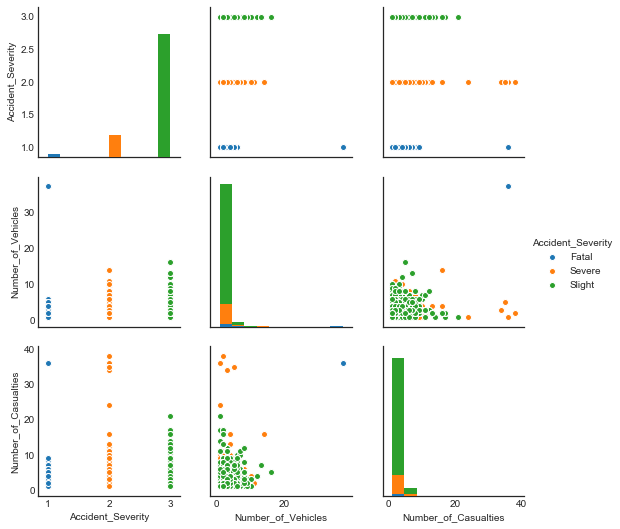

In [60]:
g = sns.pairplot(x_sample.join(y_sample)[sel_cols], hue="Accident_Severity")
new_labels = ['Fatal', 'Severe', 'Slight']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

In [7]:
cas_sample = pd.read_csv("./train/stratified_XY_train.oh.tlsmote.cas.v2.csv")
sample_cols = joblib.load("./train/stratified_XY_train.oh.tlsmote.cols.pkl.xz")

D:\Anaconda3\envs\FYP_TAP_ENV\lib\site-packages\ipykernel_launcher.py:193: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.


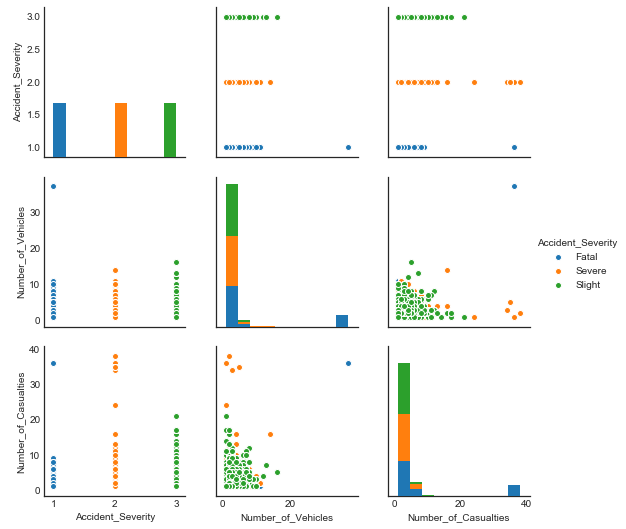

In [62]:
rev_cas_sample = reverse_dummy(cas_sample)
rev_cas_sample["Accident_Severity"] = cas_sample["Accident_Severity"].copy()
_, x_sample, _, y_sample = train_test_split(rev_cas_sample[rev_cas_sample.columns[rev_cas_sample.columns.isin(sel_cols)]].drop("Accident_Severity", axis=1), rev_cas_sample["Accident_Severity"], 
                                           test_size=0.2, stratify=rev_cas_sample["Accident_Severity"])
g = sns.pairplot(x_sample.join(y_sample)[sel_cols], hue="Accident_Severity")
new_labels = ['Fatal', 'Severe', 'Slight']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

In [63]:
rs_casres = pd.read_csv("./search/rf/randomsearch_rf.cas.v2.csv").sort_values("rank_test_f1_macro")
rs_nocasres = pd.read_csv("./search/rf/randomsearch_rf.nocas.v2.csv").sort_values("rank_test_f1_macro")

In [64]:
rs_casres[[
    'mean_test_accuracy',
    'mean_test_f1_macro', 'mean_test_precision_macro',
    'mean_test_recall_macro', 'param_max_depth', 'param_max_features',
    'param_min_samples_leaf', 'param_n_estimators'
]]

mean_test_accuracy  mean_test_f1_macro  mean_test_precision_macro  \
3             0.986531            0.986514                   0.986631   
6             0.980107            0.980094                   0.980167   
15            0.959277            0.959232                   0.959251   
11            0.950602            0.950540                   0.950553   
10            0.939061            0.938971                   0.938982   
14            0.937910            0.937783                   0.937745   
7             0.926248            0.925983                   0.925939   
13            0.907393            0.907154                   0.907062   
17            0.906862            0.906608                   0.906548   
5             0.906547            0.906289                   0.906241   
0             0.904048            0.903768                   0.903718   
8             0.895867            0.895518                   0.895450   
16            0.893370            0.892785                   0.892802   
9             0.889908            0.889540                   0.889471   
4             0.888626            0.888243                   0.888175   
1             0.879380            0.878571                   0.878574   
19            0.718604            0.710935                   0.719252   
2             0.627044            0.612148                   0.622931   
18            0.558753            0.532223                   0.544002   
12            0.536397            0.515853                   0.518644   

    mean_test_recall_macro  param_max_depth param_max_features  \
3                 0.986531             29.0               log2   
6                 0.980107             41.0               sqrt   
15                0.959277             43.0               log2   
11                0.950602             41.0               sqrt   
10                0.939061             45.0               sqrt   
14                0.937910             35.0               log2   
7                 0.926248             27.0               sqrt   
13                0.907393             41.0               sqrt   
17                0.906862             45.0               log2   
5                 0.906547             45.0               log2   
0                 0.904048             33.0               sqrt   
8                 0.895867             37.0               log2   
16                0.893370             27.0               log2   
9                 0.889908              NaN               log2   
4                 0.888626             41.0               log2   
1                 0.879380             25.0               sqrt   
19                0.718604             13.0               log2   
2                 0.627044              9.0               log2   
18                0.558753              5.0               log2   
12                0.536397              3.0               log2   

    param_min_samples_leaf  param_n_estimators  
3                        1                  59  
6                        2                  98  
15                       3                 106  
11                       4                  86  
10                       5                 108  
14                       4                  79  
7                        4                 102  
13                       8                  58  
17                       7                 149  
5                        7                 118  
0                        8                 133  
8                        8                 142  
16                       6                 128  
9                        9                 102  
4                        9                  93  
1                        8                 104  
19                       3                 118  
2                        1                 124  
18                       8                 110  
12                       2                  62

In [65]:
rs_nocasres[[
    'mean_test_accuracy',
    'mean_test_f1_macro', 'mean_test_precision_macro',
    'mean_test_recall_macro', 'param_max_depth', 'param_max_features',
    'param_min_samples_leaf', 'param_n_estimators'
]]

mean_test_accuracy  mean_test_f1_macro  mean_test_precision_macro  \
2             0.959560            0.959475                   0.959706   
10            0.951576            0.951449                   0.951459   
12            0.936895            0.936719                   0.936640   
8             0.927267            0.927039                   0.926908   
7             0.901989            0.901552                   0.901352   
18            0.878371            0.877542                   0.877601   
15            0.872140            0.871175                   0.871314   
1             0.870198            0.869419                   0.869287   
4             0.870048            0.869268                   0.869163   
13            0.866425            0.865168                   0.865707   
0             0.839503            0.837126                   0.839883   
5             0.815582            0.812923                   0.814734   
16            0.737998            0.732399                   0.736911   
17            0.719490            0.713285                   0.718841   
19            0.694360            0.686181                   0.693817   
9             0.658162            0.647426                   0.654635   
14            0.645803            0.633230                   0.643163   
11            0.548347            0.511733                   0.535079   
3             0.522552            0.486800                   0.501731   
6             0.521186            0.474907                   0.499295   

    mean_test_recall_macro  param_max_depth param_max_features  \
2                 0.959560             47.0               log2   
10                0.951576             33.0               log2   
12                0.936895             45.0               log2   
8                 0.927267             47.0               sqrt   
7                 0.901989              NaN               sqrt   
18                0.878371             31.0               log2   
15                0.872140             29.0               log2   
1                 0.870198             47.0               log2   
4                 0.870048             49.0               log2   
13                0.866425             25.0               sqrt   
0                 0.839503             19.0               sqrt   
5                 0.815582             21.0               sqrt   
16                0.737998             15.0               sqrt   
17                0.719490             15.0               log2   
19                0.694360             13.0               log2   
9                 0.658162             11.0               sqrt   
14                0.645803             11.0               log2   
11                0.548347              5.0               sqrt   
3                 0.522552              3.0               sqrt   
6                 0.521186              3.0               sqrt   

    param_min_samples_leaf  param_n_estimators  
2                        2                  78  
10                       2                  75  
12                       3                 121  
8                        4                 143  
7                        6                 137  
18                       6                  99  
15                       6                  69  
1                        8                 134  
4                        8                 104  
13                       6                 107  
0                        2                  72  
5                        9                 100  
16                       7                 117  
17                       9                 116  
19                       3                 139  
9                        1                 136  
14                       4                  80  
11                       7                  82  
3                        8                  62  
6                        5                  91

In [66]:
nn_casres = pd.read_csv("./search/nn/randomsearch_nn.cas.v2.csv").sort_values("rank_test_f1_macro")
nn_nocasres = pd.read_csv("./search/nn/randomsearch_nn.nocas.v2.csv").sort_values("rank_test_f1_macro")

In [67]:
nn_nocasres[[
    'mean_score_time', 'mean_test_accuracy',
    'mean_test_f1_macro', 'mean_test_precision_macro',
    'mean_test_recall_macro',
    'param_batch_size', 'param_drop_rate',
    'param_epochs', 'param_kernel_init', 'param_optimizer', 'param_units',
    'param_units_2'
]]

mean_score_time  mean_test_accuracy  mean_test_f1_macro  \
9          4.277138            0.751348            0.749400   
7          6.412160            0.738782            0.736566   
15        11.329721            0.733103            0.727681   
16         8.561448            0.724946            0.721683   
17         7.037360            0.721539            0.718021   
1          2.911348            0.715189            0.712677   
0          1.920534            0.690980            0.688298   
14         5.099620            0.674121            0.676212   
3          3.413272            0.675943            0.675847   
2          4.256243            0.665066            0.668727   
10         4.398496            0.663705            0.665602   
18         9.975848            0.666845            0.665278   
19         6.454561            0.659902            0.660791   
12         8.522367            0.658191            0.659227   
8          3.843089            0.644820            0.647439   
13         7.780145            0.638142            0.639256   
4          5.059665            0.639495            0.637402   
5          6.720550            0.632105            0.631661   
6          4.591821            0.630714            0.629502   
11         4.819376            0.605864            0.611620   

    mean_test_precision_macro  mean_test_recall_macro  param_batch_size  \
9                    0.748143                0.751348               512   
7                    0.735459                0.738782               128   
15                   0.725178                0.733103               128   
16                   0.720104                0.724946               256   
17                   0.716612                0.721539               512   
1                    0.711693                0.715189               256   
0                    0.688715                0.690980               512   
14                   0.680389                0.674121               512   
3                    0.677351                0.675943               256   
2                    0.675757                0.665066               256   
10                   0.668993                0.663705               512   
18                   0.666801                0.666845               256   
19                   0.667758                0.659902               512   
12                   0.663599                0.658191               128   
8                    0.652216                0.644820               512   
13                   0.642305                0.638142               128   
4                    0.639592                0.639495               128   
5                    0.635975                0.632105               128   
6                    0.635606                0.630714               256   
11                   0.622227                0.605864               512   

    param_drop_rate  param_epochs param_kernel_init param_optimizer  \
9               0.2           150      lecun_normal            adam   
7               0.2           100      lecun_normal           nadam   
15              0.2           150     lecun_uniform           nadam   
16              0.2           150      lecun_normal           nadam   
17              0.2           100     glorot_normal           nadam   
1               0.2           150      lecun_normal            adam   
0               0.4            75    glorot_uniform           nadam   
14              0.4           100    glorot_uniform            adam   
3               0.5           150     lecun_uniform            adam   
2               0.5           100     lecun_uniform            adam   
10              0.3           100     lecun_uniform            adam   
18              0.4           150     lecun_uniform           nadam   
19              0.5           100    glorot_uniform           nadam   
12              0.5           100      lecun_normal            adam   
8               0.5           150     l

In [68]:
nn_casres[[
    'mean_score_time', 'mean_test_accuracy',
    'mean_test_f1_macro', 'mean_test_precision_macro',
    'mean_test_recall_macro',
    'param_batch_size', 'param_drop_rate',
    'param_epochs', 'param_kernel_init', 'param_optimizer', 'param_units',
    'param_units_2'
]]

mean_score_time  mean_test_accuracy  mean_test_f1_macro  \
0          3.354830            0.802977            0.802010   
6          6.503099            0.792429            0.790830   
2          2.615114            0.783546            0.782262   
3          2.837362            0.780397            0.778627   
11         7.987045            0.771002            0.769769   
10         5.601255            0.766466            0.763772   
19         8.789493            0.761096            0.758023   
15         5.871787            0.759203            0.756290   
4          3.406065            0.753312            0.749755   
17         9.700969            0.751539            0.748585   
8          5.901667            0.749286            0.746881   
7          3.938073            0.748034            0.743892   
13         8.024142            0.741896            0.738608   
5          5.059664            0.739335            0.736339   
9          7.663574            0.738996            0.735694   
18        11.554832            0.731576            0.730005   
16         3.815114            0.726041            0.723722   
1          4.126339            0.722678            0.721971   
12         7.111718            0.719267            0.718198   
14         7.112258            0.713997            0.713100   

    mean_test_precision_macro  mean_test_recall_macro  param_batch_size  \
0                    0.801502                0.802977               256   
6                    0.792757                0.792429               128   
2                    0.782574                0.783546               512   
3                    0.779863                0.780397               512   
11                   0.771387                0.771002               128   
10                   0.763087                0.766466               256   
19                   0.759935                0.761096               512   
15                   0.755705                0.759203               128   
4                    0.749928                0.753312               256   
17                   0.749419                0.751539               128   
8                    0.748967                0.749286               128   
7                    0.742537                0.748034               512   
13                   0.739105                0.741896               128   
5                    0.737417                0.739335               128   
9                    0.736426                0.738996               128   
18                   0.730732                0.731576               128   
16                   0.724091                0.726041               512   
1                    0.724142                0.722678               128   
12                   0.723267                0.719267               256   
14                   0.718574                0.713997               256   

    param_drop_rate  param_epochs param_kernel_init param_optimizer  \
0               0.2           100      lecun_normal           nadam   
6               0.2           100     lecun_uniform           nadam   
2               0.3           150     lecun_uniform           nadam   
3               0.3           150     glorot_normal           nadam   
11              0.3           150    glorot_uniform           nadam   
10              0.3            75     lecun_uniform           nadam   
19              0.3           100     glorot_normal           nadam   
15              0.2            75     lecun_uniform            adam   
4               0.3           150    glorot_uniform            adam   
17              0.2           150    glorot_uniform           nadam   
8               0.2           100     lecun_uniform           nadam   
7               0.5           150     lecun_uniform            adam   
13              0.2            75    glorot_uniform           nadam   
5               0.3            75     lecun_uniform           nadam   
9               0.5           100     l

# Result

In [69]:
test_data = joblib.load("./test/stratified_traintest.pkl.xz")

In [10]:
for col in reverse_dummy(train_nocas).columns:
    print(col)

D:\Anaconda3\envs\FYP_TAP_ENV\lib\site-packages\ipykernel_launcher.py:193: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.


Day_of_Week
Hour
Junction_Detail
Light_Conditions
Month
Number_of_Vehicles
Sex_of_Driver
Speed_Limit
Urban_or_Rural_Area
X1st_Point_of_Impact
X1st_Road_Class


In [9]:
for col in reverse_dummy(train_cas).columns:
    print(col)

D:\Anaconda3\envs\FYP_TAP_ENV\lib\site-packages\ipykernel_launcher.py:193: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.


Age_Band_of_Casualty
Day_of_Week
Hour
Junction_Detail
Month
Number_of_Casualties
Number_of_Vehicles
Sex_of_Casualty
Sex_of_Driver
Speed_Limit
Urban_or_Rural_Area
X1st_Point_of_Impact
X1st_Road_Class


## Random Forest

In [4]:
rf_cas = joblib.load("./final/rf.final.cas.v2.pkl.xz")
train_cas = pd.read_csv("./train/stratified_XY_train.oh.tlsmote.cas.v2.csv")
rf_nocas = joblib.load("./final/rf.final.nocas.v2.pkl.xz")
train_nocas = pd.read_csv("./train/stratified_XY_train.oh.tlsmote.nocas.v2.csv")
test_data_oh = joblib.load("./test/stratified_traintest.oh.pkl.xz")

In [79]:
rf_nocas["model"]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=45, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=3,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [71]:
rf_cas["model"]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=43, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=3,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

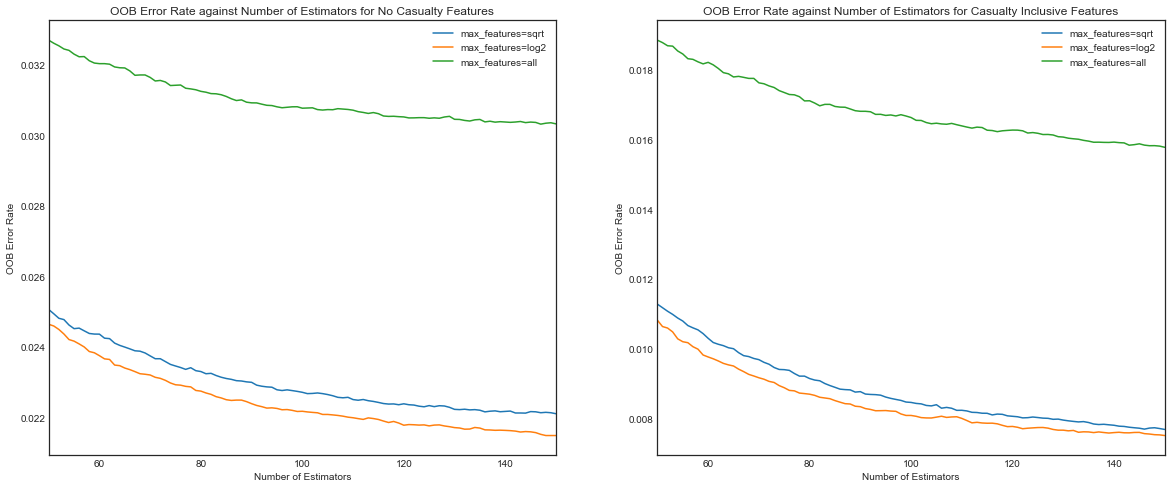

In [72]:
nocas_oob = joblib.load("./rf_oob/rf_oob-score.nocas.v2.pkl.xz")
cas_oob = joblib.load("./rf_oob/rf_oob-score.cas.v2.pkl.xz")

fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(121)
plot_rf_oob(nocas_oob, ax=ax, title="OOB Error Rate against Number of Estimators for No Casualty Features")

ax = fig.add_subplot(122)
plot_rf_oob(cas_oob, ax=ax, title="OOB Error Rate against Number of Estimators for Casualty Inclusive Features")
plt.show()

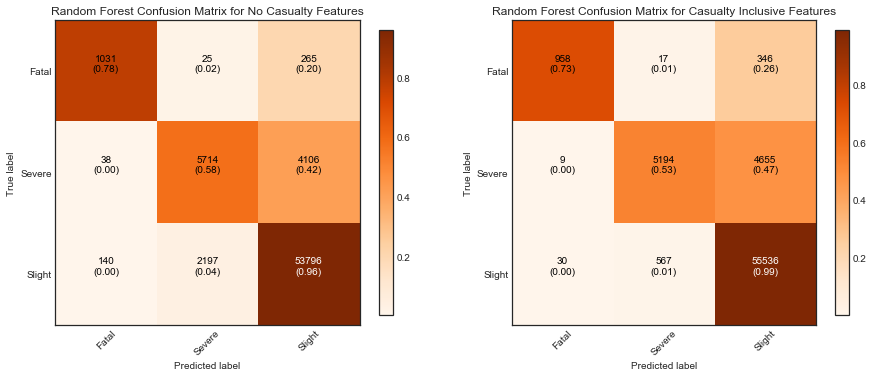

In [73]:
fig = plt.figure(figsize=[15, 15])
ax = fig.add_subplot(121)
im = plot_confusion_matrix(cm=rf_nocas["result"]["confusion_matrix"], ax=ax,
                      classes=["Fatal", "Severe", "Slight"], cmap=plt.cm.Oranges,
                      title="Random Forest Confusion Matrix for No Casualty Features")

ax = fig.add_subplot(122)
im = plot_confusion_matrix(cm=rf_cas["result"]["confusion_matrix"], ax=ax,
                      classes=["Fatal", "Severe", "Slight"], cmap=plt.cm.Oranges,
                      title="Random Forest Confusion Matrix for Casualty Inclusive Features")

plt.show()


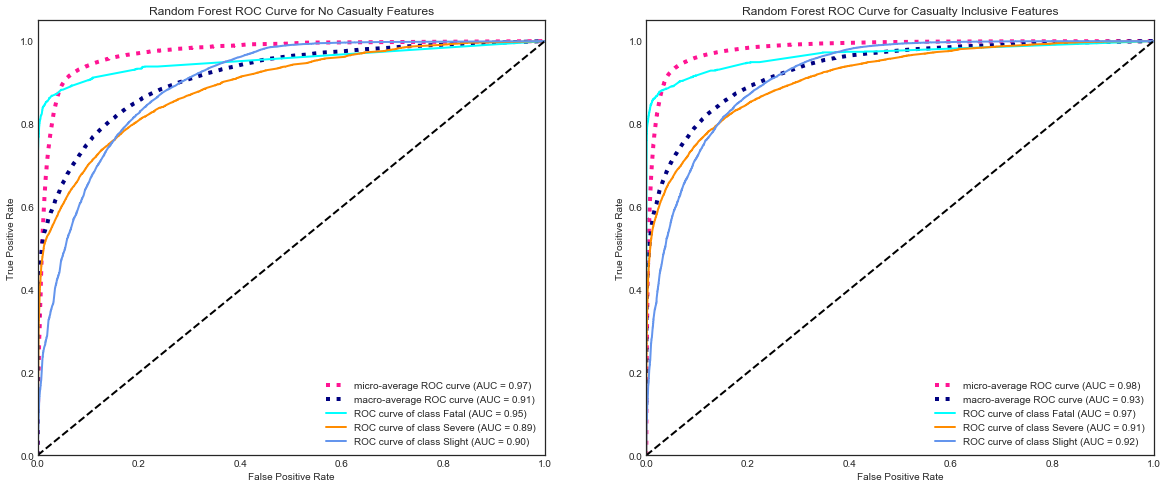

In [12]:
rf_roc_nocas = joblib.load("./final/roc_auc_score-all.oh.tlsmote.nocas.v2.rf.pkl.xz")
rf_roc_cas = joblib.load("./final/roc_auc_score-all.oh.tlsmote.cas.v2.rf.pkl.xz")

fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(121)
plot_roc_auc_curve(rf_roc_nocas, ax=ax, title="Random Forest ROC Curve for No Casualty Features")

ax = fig.add_subplot(122)
plot_roc_auc_curve(rf_roc_cas , ax=ax, title="Random Forest ROC Curve for Casualty Inclusive Features")
plt.show()

In [8]:
rf_nocas["fi"] = rf_nocas["model"].feature_importances_
rf_cas["fi"] = rf_cas["model"].feature_importances_

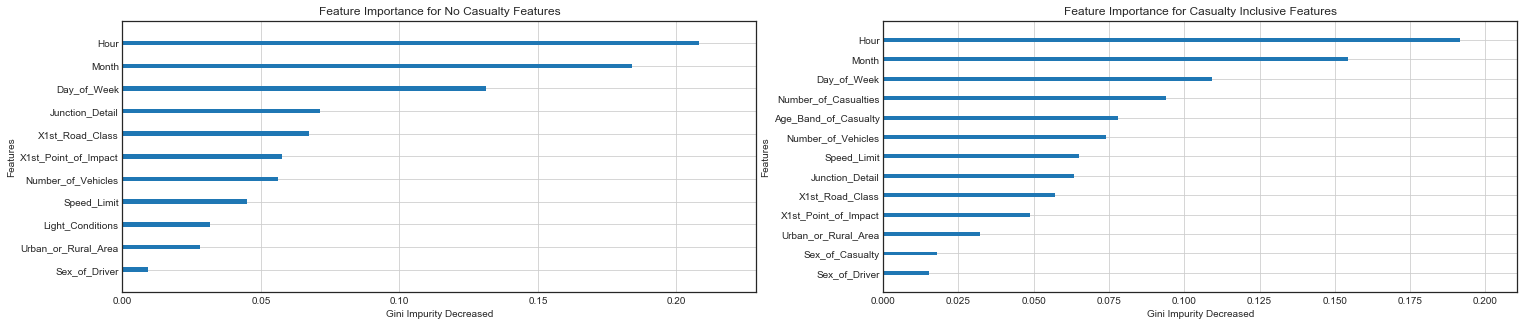

In [10]:
fig = plt.figure(figsize=[25, 5])
ax = fig.add_subplot(121)
fi_cas = remap_feature_importances(train_nocas[sample_cols["nocascols"]], rf_nocas["fi"])
xgb.plot_importance(fi_cas, ax=ax, show_values=False, xlabel="Gini Impurity Decreased", 
                    title="Feature Importance for No Casualty Features")

ax.set_facecolor("white")
ax = fig.add_subplot(122)
fi_cas = remap_feature_importances(sample_cols["cascols"], rf_cas["fi"])
xgb.plot_importance(fi_cas, ax=ax, show_values=False, xlabel="Gini Impurity Decreased", 
                    title="Feature Importance for Casualty Inclusive Features")
ax.set_facecolor("white")
plt.show()

In [18]:
met.parse_evaluate_model_print(rf_nocas["result"])

name:
nocas-final

accuracy:
0.8994087235559781

confusion_matrix:
[[ 1031    25   265]
 [   38  5714  4106]
 [  140  2197 53796]]

report:
                   pre       rec       spe        f1       geo       iba       sup

          1       0.85      0.78      1.00      0.82      0.92      0.84      1321
          2       0.72      0.58      0.96      0.64      0.82      0.66      9858
          3       0.92      0.96      0.61      0.94      0.83      0.70     56133

avg / total       0.89      0.90      0.67      0.90      0.83      0.70     67312


sensitivity:
0.7728222780994428

specificity:
0.8558757535671128

f1_micro:
0.8994087235559781

f1_weighted:
0.8950338438715346

f1_macro:
0.7995236852518789



In [46]:
met.parse_evaluate_model_print(rf_cas["result"])

name:
cas-final

accuracy:
0.9164487758497741

confusion_matrix:
[[  958    17   346]
 [    9  5194  4655]
 [   30   567 55536]]

report:
                   pre       rec       spe        f1       geo       iba       sup

          1       0.96      0.73      1.00      0.83      0.98      0.95      1321
          2       0.90      0.53      0.99      0.66      0.91      0.83      9858
          3       0.92      0.99      0.55      0.95      0.91      0.84     56133

avg / total       0.92      0.92      0.63      0.91      0.92      0.84     67312


sensitivity:
0.7471514803249116

specificity:
0.8472959019981544

f1_micro:
0.9164487758497741

f1_weighted:
0.9074290389512684

f1_macro:
0.8143191448676311



## ANN

In [25]:
nn_cas = joblib.load("./final/nn.val.final.cas.v2.pkl.xz")
nn_model_cas = load_model("./final/nn.model.val.final.cas.v2.h5")
nn_nocas = joblib.load("./final/nn.val.final.nocas.v2.pkl.xz")
nn_model_nocas = load_model("./final/nn.model.val.final.nocas.v2.h5")
epochs = np.arange(1, 201, 1)

In [19]:
display(HTML("<table><tr><td><img src='./nn_model_nocas.png'></td><td><img src='./nn_model_cas.png'></td></tr></table>"))

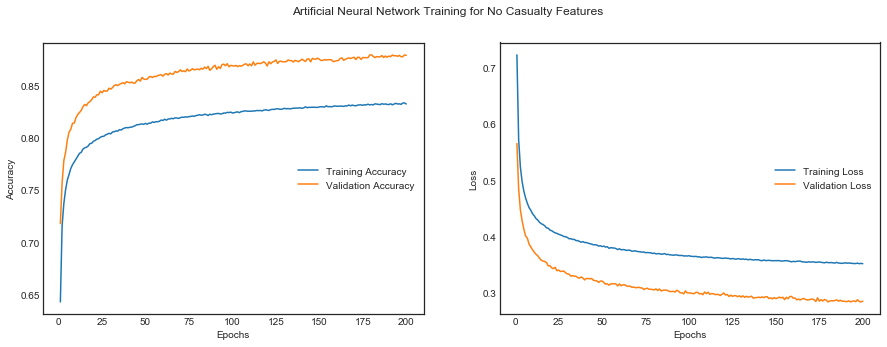

In [49]:
fig = plt.figure(figsize=[15, 5])
ind = 121

ax = fig.add_subplot(ind)
x, y = simple_line_numeric(epochs, nn_nocas["history"]["categorical_accuracy"])
l1 = ax.plot(x, y, label="Training Accuracy")
x, y = simple_line_numeric(epochs, nn_nocas["history"]["val_categorical_accuracy"])
l2 = ax.plot(x, y, label="Validation Accuracy")
ax.legend(loc="center right")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ind += 1

ax = fig.add_subplot(ind)
x, y = simple_line_numeric(epochs, nn_nocas["history"]["loss"])
l1 = ax.plot(x, y, label="Training Loss")
x, y = simple_line_numeric(epochs, nn_nocas["history"]["val_loss"])
l2 = ax.plot(x, y, label="Validation Loss")
ax.legend(loc="center right")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ind += 1

fig.suptitle("Artificial Neural Network Training for No Casualty Features")
plt.show()

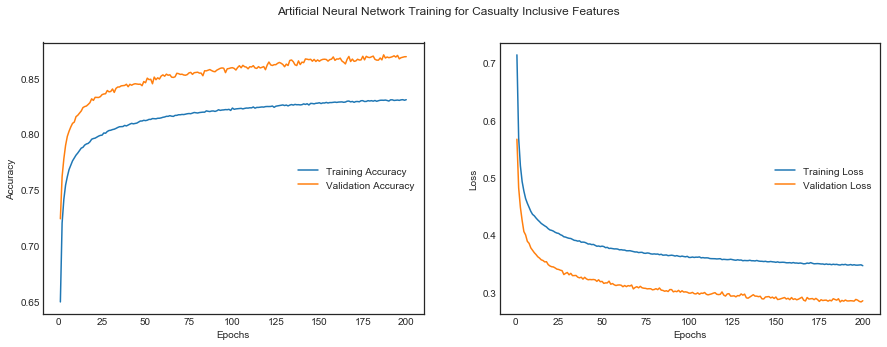

In [50]:
fig = plt.figure(figsize=[15, 5])
ind = 121

ax = fig.add_subplot(ind)
x, y = simple_line_numeric(epochs, nn_cas["history"]["categorical_accuracy"])
l1 = ax.plot(x, y, label="Training Accuracy")
x, y = simple_line_numeric(epochs, nn_cas["history"]["val_categorical_accuracy"])
l2 = ax.plot(x, y, label="Validation Accuracy")
ax.legend(loc="center right")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ind += 1

ax = fig.add_subplot(ind)
x, y = simple_line_numeric(epochs, nn_cas["history"]["loss"])
l1 = ax.plot(x, y, label="Training Loss")
x, y = simple_line_numeric(epochs, nn_cas["history"]["val_loss"])
l2 = ax.plot(x, y, label="Validation Loss")
ax.legend(loc="center right")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ind += 1

fig.suptitle("Artificial Neural Network Training for Casualty Inclusive Features")
plt.show()

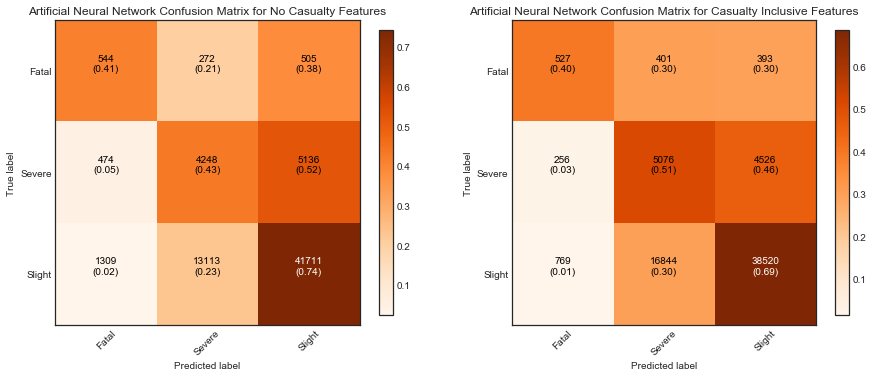

In [51]:
fig = plt.figure(figsize=[15, 15])
ax = fig.add_subplot(121)
im = plot_confusion_matrix(cm=nn_nocas["result"]["confusion_matrix"], ax=ax,
                      classes=["Fatal", "Severe", "Slight"], cmap=plt.cm.Oranges,
                      title="Artificial Neural Network Confusion Matrix for No Casualty Features")

ax = fig.add_subplot(122)
im = plot_confusion_matrix(cm=nn_cas["result"]["confusion_matrix"], ax=ax,
                      classes=["Fatal", "Severe", "Slight"], cmap=plt.cm.Oranges,
                      title="Artificial Neural Network Confusion Matrix for Casualty Inclusive Features")

plt.show()


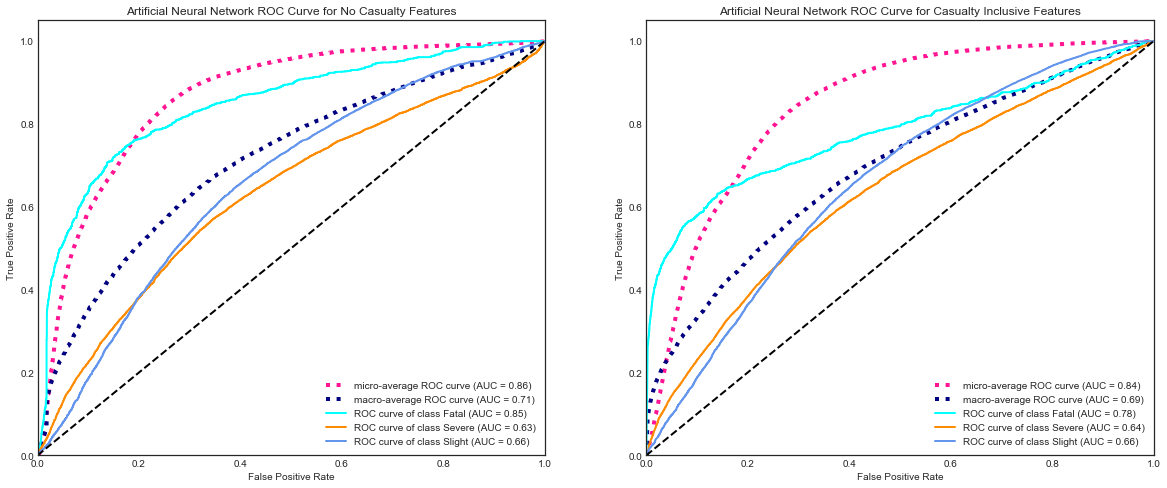

In [23]:
nn_roc_nocas = joblib.load("./final/roc_auc_score-all.oh.tlsmote.nocas.v2.nn2.pkl.xz")
nn_roc_cas = joblib.load("./final/roc_auc_score-all.oh.tlsmote.cas.v2.nn2.pkl.xz")

fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(121)
plot_roc_auc_curve(nn_roc_nocas, ax=ax, title="Artificial Neural Network ROC Curve for No Casualty Features")

ax = fig.add_subplot(122)
plot_roc_auc_curve(nn_roc_cas , ax=ax, title="Artificial Neural Network ROC Curve for Casualty Inclusive Features")
plt.show()

In [27]:
met.parse_evaluate_model_print(nn_nocas["result"])

name:
.nocas.v2

accuracy:
0.6908574994057524

confusion_matrix:
[[  544   272   505]
 [  474  4248  5136]
 [ 1309 13113 41711]]

report:
                   pre       rec       spe        f1       geo       iba       sup

          1       0.23      0.41      0.97      0.30      0.48      0.21      1321
          2       0.24      0.43      0.77      0.31      0.46      0.20      9858
          3       0.88      0.74      0.50      0.81      0.49      0.26     56133

avg / total       0.77      0.69      0.54      0.72      0.49      0.25     67312


sensitivity:
0.5286009232534258

specificity:
0.7451351093606373

f1_micro:
0.6908574994057524

f1_weighted:
0.7233608000374293

f1_macro:
0.47113956762177



In [26]:
met.parse_evaluate_model_print(nn_cas["result"])

name:
.cas.v2

accuracy:
0.655499762300927

confusion_matrix:
[[  527   401   393]
 [  256  5076  4526]
 [  769 16844 38520]]

report:
                   pre       rec       spe        f1       geo       iba       sup

          1       0.34      0.40      0.98      0.37      0.58      0.31      1321
          2       0.23      0.51      0.70      0.32      0.45      0.19      9858
          3       0.89      0.69      0.56      0.77      0.48      0.25     56133

avg / total       0.78      0.66      0.59      0.70      0.48      0.24     67312


sensitivity:
0.533359765506412

specificity:
0.7480976480252433

f1_micro:
0.655499762300927

f1_weighted:
0.6986187849519915

f1_macro:
0.4853535482801153

